# TUTORIAL: SEGMENTACIÓN DE IMÁGENES SATELITALES USANDO REDES CONVOLUCIONALES

En este tutorial veremos cómo crear, entrenar y poner a prueba la red U-Net, basada en Redes Convolucionales, para segmentar imágenes satelitales.

Contenido:
1. [¿Qué es la segmentación?](#scrollTo=a__S30X3nlbv&line=8&uniqifier=1)
2. [Aplicaciones de la segmentación](#scrollTo=X437bCxYno-3&line=5&uniqifier=1)
3. [El problema a resolver](#scrollTo=-fN_IjP6nrtS&line=3&uniqifier=1)
4. [La segmentación con Redes Convolucionales: U-Net](#scrollTo=p0PgBzu-nuNV&line=1&uniqifier=1)
5. [El set de datos](#scrollTo=nsfWE-mw_Rvv&line=15&uniqifier=1)
6. [Creación y entrenamiento de U-Net](#scrollTo=_2NWkDMngemL&line=12&uniqifier=1)
7. [Segmentación de imágenes con el modelo entrenado](#scrollTo=oH4JBU1Wncu_&line=1&uniqifier=1)


## 1. ¿Qué es la segmentación?

> Consiste en clasificar **cada pixel** de una imagen en una de varias posibles categorías

![](https://drive.google.com/uc?export=view&id=1tXu_sDB-0-5nTY0QAkNPUdFCDr89pWPt)

Así que tanto a la entrada como a la salida tendremos imágenes.

## 2. Aplicaciones de la segmentación

- Vehículos autónomos
- Análisis de imágenes médicas
- Análisis de imágenes satelitales

## 3. El problema a resolver

> Entrenar y poner a prueba una Red Convolucional capaz de segmentar imágenes

## 4. La segmentación con Redes Convolucionales: U-Net

Las Redes Convolucionales son la arquitectura ideal para la segmentación de imágenes.

Una de las arquitecturas más usadas es U-Net, desarrollada en el año 2015 para la segmentación de imágenes médicas:

![](https://drive.google.com/uc?export=view&id=1t_Cmqjvd_fnE6zbsa5F3KtxgBOn3pYUf)

El principio de funcionamiento de U-Net es sencillo y se basa en estos componentes:

- **Codificador**: capas convolucionales que aprender a extraer las características más relevantes de las imágenes de entrada y a codificarlas como un vector
- **Decodificador**: capas convolucionales **inversas** que permiten **reconstruir** la imagen a partir de la codificación
- **Skip connections** (conexiones directas): permiten interconectar capas equivalentes entre codificador y decodificador. Es una manera de presentarle al decodificador los detalles locales y globales de las imágenes de entrada

## 5. El set de datos

Usaremos un [set de datos](https://drive.google.com/drive/folders/1KIV_N6V71BVMEtX6nyRYivT0ZDrQQGTE?usp=drive_link) que contiene imágenes 5.535 imágenes satelitales con sus correspondientes máscaras de segmentación:

![](https://drive.google.com/uc?export=view&id=1u2l2MF4vmUxIQCCth-qVE1E0GqMDXKUs)

Algunas características:

- Imágenes y máscaras: tamaño de 128x128
- Rango de valores pixeles imágenes: 0 a 255
- Rango de valores pixeles máscaras:
  - *construcción* -> 0
  - *tierra* -> 1
  - *vía* -> 2
  - *vegetación* -> 3
  - *agua* -> 4
  - *otro* -> 5

### 5.1. Lectura del set de datos

Los pasos para poder leer el set de datos son los siguientes:

1. Descargar los archivos (*imgs.zip*, *msks.zip*, *metadata.csv*) localmente desde el [enlace de descarga](https://drive.google.com/drive/folders/1KIV_N6V71BVMEtX6nyRYivT0ZDrQQGTE?usp=drive_link)
2. Cargarlos en Google Drive
3. Montar Google Drive en Google Colab:

A continuación descomprimimos los archivos *imgs.zip* (imágenes) y *msks.zip* (máscaras de segmentación), especificando en cada caso la ruta donde están almacenados en Google Drive:

Ahora leemos el archivo de meta-datos (*metadata.csv*).

Este archivo es clave pues tiene el listado completo de imágenes y máscaras que usaremos para crear los datasets de TensorFlow:

In [17]:
# Leer metadatos
import pandas as pd

ruta = "Datos/tuto_boyaca/metadata.csv"
df = pd.read_csv(ruta)
df

imgs                        msks
0           img_row_0_col_0.jpg        mask_row_0_col_0.jpg
1          img_row_0_col_64.jpg       mask_row_0_col_64.jpg
2         img_row_0_col_128.jpg      mask_row_0_col_128.jpg
3         img_row_0_col_192.jpg      mask_row_0_col_192.jpg
4         img_row_0_col_256.jpg      mask_row_0_col_256.jpg
...                         ...                         ...
1051  img_row_1984_col_1792.jpg  mask_row_1984_col_1792.jpg
1052  img_row_1984_col_1856.jpg  mask_row_1984_col_1856.jpg
1053  img_row_1984_col_1920.jpg  mask_row_1984_col_1920.jpg
1054  img_row_1984_col_1984.jpg  mask_row_1984_col_1984.jpg
1055  img_row_1984_col_2048.jpg  mask_row_1984_col_2048.jpg

[1056 rows x 2 columns]

### 5.2. Preparación del set de datos

En esta fase debemos:

1. Mezclar aleatoriamente las filas de *metadata.csv*
2. Generar las particiones para entrenamiento, validación y prueba (80%/10%/10%)
3. Crear los datasets de TensorFlow **teniendo en cuenta que aún no leeremos los datos** (para evitar problemas de almacenamiento en la RAM)

Veamos la primera parte de este preprocesamiento. Comencemos mezclando aleatoriamente las filas de *metadata.csv*:

In [18]:
# Mezclar aleatoriamente filas de metadata.csv
df = df.sample(frac=1, random_state=23)
df

imgs                        msks
569    img_row_1088_col_512.jpg   mask_row_1088_col_512.jpg
829    img_row_1600_col_256.jpg   mask_row_1600_col_256.jpg
334     img_row_640_col_256.jpg    mask_row_640_col_256.jpg
207     img_row_384_col_576.jpg    mask_row_384_col_576.jpg
1027   img_row_1984_col_256.jpg   mask_row_1984_col_256.jpg
...                         ...                         ...
237     img_row_448_col_384.jpg    mask_row_448_col_384.jpg
31       img_row_0_col_1984.jpg     mask_row_0_col_1984.jpg
950   img_row_1792_col_1664.jpg  mask_row_1792_col_1664.jpg
742   img_row_1408_col_1024.jpg  mask_row_1408_col_1024.jpg
595     img_row_1152_col_64.jpg    mask_row_1152_col_64.jpg

[1056 rows x 2 columns]

Ahora calculemos la cantidad de datos de entrenamiento (80%), validación (10%) y prueba (10%):

In [19]:
# Tamaños sets train, val, test
N = df.shape[0] # Cantidad total de datos
n_train = int(0.8*N) # Cantidad de datos de entrenamiento
n_val = int(0.1*N) # Cantidad de datos de validación
n_test = N - n_train - n_val # Cantidad de datos de prueba

print(N, n_train, n_val, n_test)

1056 844 105 107


Ahora generemos las particiones.

Cada partición será simplemente un arreglo con el listado de nombres de las imágenes (arreglos "x") y de sus correspondientes máscaras (arreglos "y"):

In [20]:
# Arreglos entrenamiento
x_train_fnames = df['imgs'].values[0:n_train]
y_train_fnames = df['msks'].values[0:n_train]

# Arreglos validación
x_val_fnames = df['imgs'].values[n_train:n_train+n_val]
y_val_fnames = df['msks'].values[n_train:n_train+n_val]

# Arreglos prueba
x_test_fnames = df['imgs'].values[n_train+n_val:]
y_test_fnames = df['msks'].values[n_train+n_val:]

for name1, name2 in zip(x_train_fnames, y_train_fnames):
    print(name1,name2)

img_row_1088_col_512.jpg mask_row_1088_col_512.jpg
img_row_1600_col_256.jpg mask_row_1600_col_256.jpg
img_row_640_col_256.jpg mask_row_640_col_256.jpg
img_row_384_col_576.jpg mask_row_384_col_576.jpg
img_row_1984_col_256.jpg mask_row_1984_col_256.jpg
img_row_832_col_1792.jpg mask_row_832_col_1792.jpg
img_row_768_col_320.jpg mask_row_768_col_320.jpg
img_row_1344_col_1856.jpg mask_row_1344_col_1856.jpg
img_row_1792_col_0.jpg mask_row_1792_col_0.jpg
img_row_1664_col_320.jpg mask_row_1664_col_320.jpg
img_row_896_col_960.jpg mask_row_896_col_960.jpg
img_row_1728_col_320.jpg mask_row_1728_col_320.jpg
img_row_1728_col_1152.jpg mask_row_1728_col_1152.jpg
img_row_1216_col_1024.jpg mask_row_1216_col_1024.jpg
img_row_1216_col_0.jpg mask_row_1216_col_0.jpg
img_row_512_col_576.jpg mask_row_512_col_576.jpg
img_row_1664_col_1408.jpg mask_row_1664_col_1408.jpg
img_row_128_col_1344.jpg mask_row_128_col_1344.jpg
img_row_1920_col_1536.jpg mask_row_1920_col_1536.jpg
img_row_768_col_1728.jpg mask_row_768_c

Vemos que estos arreglos no contienen como tal las imágenes/máscaras sino simplemente el nombre de los archivos.

Esto es suficiente para crear el dataset de TensorFlow:

In [21]:
import tensorflow as tf

ds_train = tf.data.Dataset.from_tensor_slices((x_train_fnames, y_train_fnames))
ds_val = tf.data.Dataset.from_tensor_slices((x_val_fnames, y_val_fnames))
ds_test = tf.data.Dataset.from_tensor_slices((x_test_fnames, y_test_fnames))

print(len(ds_train), len(ds_val), len(ds_test))

844 105 107


Bien, ya tenemos los datasets de entrenamiento (`ds_train`), validación (`ds_val`) y prueba (`ds_test`).

Verifiquemos que estos dataset no contienen como tal las imágenes/máscaras sino únicamente los nombres de los archivos:

In [22]:
for img_fname, msk_fname in ds_test.take(1):
    print(img_fname.numpy(),msk_fname.numpy())

b'img_row_1664_col_1792.jpg' b'mask_row_1664_col_1792.jpg'


2025-03-27 16:29:07.709071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Más adelante, cuando entrenemos el modelo, TensorFlow/Keras realizará la lectura de las imágenes.

Ahora creemos la función `preprocesar_imagen` que será ejecutada durante este entrenamiento. Esta función llevará a cabo estos pasos:

1. Leerá las imágenes/máscaras desde los directorios correspondientes
2. Convertirá cada imagen del formato *uint8* (enteros 8 bits, sin signo) al formato *float32* (punto flotante) para que sus pixeles estén en la escala de 0 a 1 (en lugar de 0 a 255)
3. Retornará la imagen y la máscara

In [23]:
# Fijar directorios para las imágenes y las máscaras
DIR_IMGS = 'Datos/tuto_boyaca/img/'
DIR_MSKS = 'Datos/tuto_boyaca/mask/'


# La función para lectura y pre-procesamiento
def preprocesar_imagen(imgpath, mskpath):
    # Leer imagen y máscara
    img = tf.io.read_file(DIR_IMGS + imgpath)
    msk = tf.io.read_file(DIR_MSKS + mskpath)

    # Decodificar imagen con "decode_jpeg" (3 canales)
    # y máscara con "decode_png" (1 canal)
    img = tf.image.decode_jpeg(img, channels=3) #uint8
    msk = tf.image.decode_png(msk, channels=1) #uint8

    # Convertir la imagen a "float32"
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    return img, msk

Bien, verifiquemos si `preprocesar_imagen` funciona correctamente. Para ello:

- Tomamos el set de validación (`ds_val`)
- Aplicamos la función `preprocesar_imagen` con ayuda de `map()`
- Tomamos un dato con `take()` y mostramos tanto la imagen como la máscara

(128, 128, 3)
(128, 128, 1)


2025-03-27 16:29:20.775244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


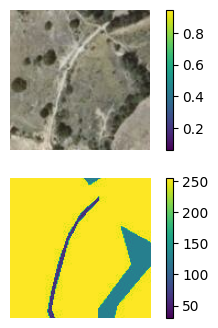

In [24]:
# Extraer la primera imagen del set de entrenamiento
ds_mini = ds_val.map(preprocesar_imagen).take(1)

# Imprimir tamaño y categoría
for img, msk in ds_mini:
    print(img.numpy().shape)
    print(msk.numpy().shape)

# Y graficarlas
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))

plt.subplot(2,1,1)
plt.imshow(img)
plt.axis('off')
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(msk)
plt.axis('off')
plt.colorbar();

Veamos en detalle la máscara de segmentación:

In [12]:
# Máscara en detalle
import plotly.express as px

fig = px.imshow(msk.numpy().squeeze())
fig.show()

En este caso la imagen sólo contiene las categorías 2 (vegetación) y 3 (vías).

Con esto ya estamos listos para implementar la Red U-Net.

## 6. Creación y entrenamiento de U-Net

Usaremos TensorFlow/Keras para crear una versión modificada de la Red U-Net. Nuestra red tendrá estas características:

| **Bloque** | **Características** |
|----------------------|------------------------------------------------------|
| Entrada | Input, 128x128x3 |
| Codificador | - **conv1**: Conv2D, 16 filtros, 3x3, ReLU (x2)<br> - **pool1**: Maxpooling, 2x2<br><br>- **conv2**Conv2D, 32 filtros, 3x3, ReLU (x2)<br>- **pool2**: Maxpooling, 2x2<br><br>- **conv3**: Conv2D, 64 filtros, 3x3, ReLU (x2)<br> - **pool3**: Maxpooling, 2x2<br><br>- **conv4**: Conv2D, 128 filtros, 3x3, ReLU (x2)<br>- **pool4**: Maxpooling, 2x2<br><br>- **conv5**: Conv2D, 256 filtros, 3x3, ReLU (x2)|
| Decodificador | - **dec1**: Conv2DTranspose, 128 filtros, 2x2<br> - **dec1**: concatenate(dec1, conv4)<br>- **dec1**: Conv2DTranspose, 128 filtros, 3x3 (x2)<br><br> - **dec2**: Conv2DTranspose, 64 filtros, 2x2<br> - **dec2**: concatenate(dec2,conv3)<br> - **dec2**: Conv2DTranspose, 64 filtros, 3x3 (x2)<br><br> - **dec3**: Conv2DTranspose, 32 filtros, 2x2<br> - **dec3**: concatenate(dec3,conv2)<br> - **dec3**: Conv2DTranspose, 32 filtros, 3x3 (x2)<br><br> - **dec4**: Conv2DTranspose, 16 filtros, 2x2<br> - **dec4**: concatenate(dec4,conv1)<br> - **dec4**:  - Conv2DTranspose, 16 filtros, 3x3 (x2)<br><br>
| Salida | Conv2D, 6 filtros, 1x1, softmax

Veamos entonces cómo implementar la red en TensorFlow/Keras:

In [13]:
from tensorflow.keras import layers

# Fijar la semilla
tf.random.set_seed(123)

# Tamaños entrada y número de categorías
img_size = (128,128,3) # El tamaño de cada patch
nclases = 6

# ===============
# Entrada
entrada = tf.keras.Input(shape=img_size)

# ===============
# Codificador

# conv1
conv1 = layers.Conv2D(16,(3,3),activation='relu',padding='same')(entrada)
conv1 = layers.Conv2D(16,(3,3),activation='relu',padding='same')(conv1)
pool1 = layers.MaxPool2D((2,2))(conv1)

# conv2
conv2 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(pool1)
conv2 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(conv2)
pool2 = layers.MaxPool2D((2,2))(conv2)

# conv3
conv3 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(pool2)
conv3 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv3)
pool3 = layers.MaxPool2D((2,2))(conv3)

# conv4
conv4 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(pool3)
conv4 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv4)
pool4 = layers.MaxPool2D((2,2))(conv4)

# conv5
conv5 = layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool4)
conv5 = layers.Conv2D(256,(3,3),activation='relu',padding='same')(conv5)

# ===============
# Decodificador

# dec1
dec1 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)
dec1 = layers.concatenate([dec1,conv4])
dec1 = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(dec1)
dec1 = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(dec1)

# dec2
dec2 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(dec1)
dec2 = layers.concatenate([dec2,conv3])
dec2 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(dec2)
dec2 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(dec2)

# dec3
dec3 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(dec2)
dec3 = layers.concatenate([dec3,conv2])
dec3 = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(dec3)
dec3 = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(dec3)

# dec4
dec4 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(dec3)
dec4 = layers.concatenate([dec4,conv1])
dec4 = layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(dec4)
dec4 = layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(dec4)

# ===============
# Salida
salida = layers.Conv2D(filters=6, kernel_size=(1,1), activation='softmax')(dec4)

# ===============
# Interconectar todo en un modelo
unet = tf.keras.models.Model(inputs=entrada, outputs=salida)
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

Muy bien, habiendo creado el modelo el siguiente paso es compilarlo, es decir definir el optimizador y la pérdida a optimizar.

Como optimizador usaremos Adam (`optimizer = 'adam'`) y como función de error usaremos la entropía cruzada (`loss = 'sparse_categorical_crossentropy'`):

In [14]:
unet.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
)

Perfecto! Sólo nos falta entrenar el modelo.

Primero tenemos que crear lotes (*batches*) de los sets de entrenamiento y validación, para evitar leer todos los datos y tener problemas de memoria RAM.

Usaremos lotes de 16 datos y los crearemos con el método `batch`:

In [15]:
# Definir el batch size
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VAL = 16

# Crear los lotes (aún no leemos las imágenes)
train_batch = ds_train.map(preprocesar_imagen).batch(BATCH_SIZE_TRAIN)
val_batch = ds_val.map(preprocesar_imagen).batch(BATCH_SIZE_VAL)

Y con esto ya podemos entrenar el modelo usando sólo una línea de código y el método `fit()`.

Se sugiere usar la GPU y al menos 20 iteraciones de entrenamiento:

In [16]:
# Y entrenar el modelo: ¡en este punto SÍ se leen las imágenes!
unet.fit(train_batch,
         validation_data = val_batch,
         epochs=10,
         verbose=2)

Epoch 1/10


2025-03-27 16:27:29.583450: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 255 which is outside the valid range of [0, 6).  Label values: 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 107 129 129 124 122 134 130 119 124 135 131 127 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 115 119 131 130 127 126 122 119 132 251 254 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/asyncio/base_events.py", line 618, in run_forever

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/asyncio/base_events.py", line 1951, in _run_once

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/asyncio/events.py", line 84, in _run

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/qh/5bmv1f155j34j21jkvcw3blh0000gn/T/ipykernel_28505/1951296348.py", line 2, in <module>

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 316, in compute_loss

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/losses/losses.py", line 1722, in sparse_categorical_crossentropy

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/Users/ivankarrillin/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 638, in sparse_categorical_crossentropy

Received a label value of 255 which is outside the valid range of [0, 6).  Label values: 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 107 129 129 124 122 134 130 119 124 135 131 127 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 115 119 131 130 127 126 122 119 132 251 254 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 144 134 125 126 131 123 127 132 125 110 116 136 133 112 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 135 142 124 113 129 141 132 134 131 255 251 253 248 254 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 241 124 111 135 125 130 133 114 129 138 141 137 124 121 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 123 125 133 136 129 118 111 118 106 255 253 255 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 133 118 129 128 119 136 122 109 121 134 123 118 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 121 120 130 130 117 123 149 146 122 255 248 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 226 255 134 123 146 117 131 118 130 130 121 124 130 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 124 114 128 133 120 112 120 112 255 251 255 252 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 252 255 236 125 129 134 122 126 131 123 125 133 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 121 120 137 132 124 138 134 142 249 255 255 255 253 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 254 248 247 255 247 252 236 153 119 130 120 121 133 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 131 130 127 120 107 152 240 254 247 255 249 246 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 232 254 255 246 255 255 250 255 247 255 235 146 117 133 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 251 255 251 246 255 255 245 255 255 255 250 255 255 255 249 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 126 126 126 126 126 126 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 253 253 253 253 253 253 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 251 252 253 255 248 254 246 255 254 247 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 251 254 255 247 252 252 255 255 255 255 255 255 248 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 253 255 247 255 228 247 252 253 240 243 255 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 249 244 255 226 255 255 255 255 254 253 255 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 253 253 255 255 255 248 244 244 248 255 255 250 241 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 252 248 245 255 255 250 235 255 253 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 255 251 238 255 61 255 252 235 255 255 250 255 254 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 250 255 242 64 65 63 68 243 255 239 255 251 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 253 247 65 81 55 64 49 76 255 255 254 255 255 251 255 248 255 255 246 255 243 255 248 255 249 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 249 244 255 255 236 66 69 82 51 57 50 255 250 255 251 255 255 252 233 255 232 255 253 255 253 255 245 252 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 255 249 240 255 255 236 255 71 70 74 61 61 59 255 240 252 255 255 251 255 238 255 249 243 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 245 255 255 246 255 255 251 255 244 53 82 45 80 68 63 71 250 248 255 240 255 250 255 255 248 255 239 253 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 236 255 255 245 255 255 235 255 235 255 255 246 250 246 60 51 69 62 48 77 255 255 255 250 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 251 252 255 249 255 255 243 255 245 255 252 253 255 255 255 58 56 78 68 38 59 58 255 236 255 244 255 238 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 255 248 255 245 246 255 255 237 255 251 255 249 255 234 250 255 255 254 59 63 84 56 49 86 244 245 255 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 245 255 250 248 255 248 242 255 247 255 248 251 255 255 254 255 241 255 246 255 64 55 60 56 66 73 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 75 53 67 57 68 67 255 255 254 255 255 243 251 250 255 255 252 252 255 253 245 255 245 251 248 255 255 255 252 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 249 255 51 62 55 60 64 65 65 240 255 255 255 255 236 250 255 248 255 248 255 249 255 255 255 249 250 235 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 229 255 255 250 68 66 66 56 76 57 245 249 250 255 246 255 255 255 250 255 245 255 250 250 255 255 251 249 245 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 243 255 255 235 254 255 52 56 81 56 60 71 255 252 255 247 255 252 248 255 250 255 255 255 246 254 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 241 255 250 255 255 255 248 255 249 53 72 43 58 54 85 61 60 255 254 254 255 255 250 255 244 255 255 240 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 252 255 255 240 254 255 243 255 240 255 255 255 253 72 65 43 51 77 46 64 73 252 250 249 255 229 255 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 241 255 244 249 251 255 246 255 255 255 239 255 248 242 79 69 49 85 58 58 55 71 59 239 255 249 255 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 252 255 241 255 255 255 252 255 254 255 242 255 255 247 255 244 255 251 63 59 59 67 57 64 72 50 61 255 237 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 253 245 66 69 56 71 45 72 62 58 69 61 255 255 250 255 255 254 247 255 255 248 248 255 255 249 252 255 251 255 248 255 249 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 225 255 255 72 65 54 65 75 48 60 53 53 75 255 248 253 255 249 246 255 251 245 248 248 255 255 245 253 255 253 255 245 252 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 239 242 244 250 255 255 250 253 255 58 50 88 59 77 69 50 65 62 67 242 255 249 251 251 255 250 254 255 243 255 255 249 243 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 254 241 249 255 244 254 255 67 45 54 64 60 64 73 52 57 75 61 64 254 247 255 253 254 255 244 250 255 255 248 255 239 253 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 247 246 252 255 250 255 255 255 240 255 251 255 253 255 255 60 65 57 53 67 66 43 60 65 63 68 51 255 255 252 255 250 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 253 249 255 253 245 255 255 255 248 248 255 255 255 234 71 62 67 72 59 74 61 59 60 66 51 63 54 255 255 236 255 244 255 238 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 255 248 255 255 255 247 254 255 235 241 255 253 244 255 255 255 237 255 247 51 58 66 63 82 42 89 66 56 61 61 49 86 244 245 255 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 248 255 255 255 252 255 255 239 255 254 252 255 255 247 249 255 255 247 255 255 255 255 252 54 80 47 57 80 50 70 60 56 66 73 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 253 245 66 69 56 59 72 57 63 65 60 66 61 68 62 65 255 245 255 255 251 255 246 253 255 255 237 253 255 248 255 255 248 255 255 232 255 249 251 255 255 254 244 255 244 255 250 255 255 246 251 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 225 255 255 255 48 68 67 69 44 78 56 61 49 67 70 62 62 56 62 69 255 248 255 236 255 255 246 255 255 255 236 255 239 255 251 255 255 240 247 255 249 251 255 250 247 247 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 239 242 244 250 255 255 255 248 255 249 249 69 70 73 74 71 52 63 64 57 68 67 61 51 66 73 54 65 81 248 255 241 251 255 240 255 255 253 238 247 255 255 245 242 255 246 255 255 255 247 255 246 245 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 254 241 255 247 255 254 255 250 240 245 249 68 50 71 58 71 68 61 58 64 71 53 63 54 52 62 55 55 69 59 70 238 243 254 255 255 242 255 255 255 255 249 243 248 252 249 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 247 246 252 255 250 255 255 255 233 255 255 225 255 255 255 246 255 248 250 255 58 52 58 57 69 51 55 74 71 43 76 65 63 78 48 60 78 66 64 45 255 255 246 228 255 240 255 255 251 249 255 249 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 253 249 255 253 251 255 239 245 255 252 255 240 255 246 255 251 255 235 255 252 255 61 70 68 53 67 77 48 62 72 44 78 75 32 58 69 67 62 72 56 255 241 255 249 253 247 255 255 247 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 255 248 255 255 255 247 252 243 255 236 251 255 252 253 239 255 237 255 240 255 255 242 255 255 243 254 255 64 50 71 63 69 47 71 55 84 85 49 66 71 46 74 55 63 59 66 255 255 255 233 255 250 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 248 255 255 255 252 255 252 255 243 255 255 244 251 255 253 255 255 246 255 255 239 255 249 255 255 255 244 255 255 255 253 65 70 52 67 60 54 71 55 75 51 64 64 68 59 61 61 61 67 66 251 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 253 245 66 69 56 59 72 57 63 65 60 66 61 65 59 68 51 68 59 73 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 225 255 255 255 48 68 67 69 44 78 56 69 57 68 61 65 61 60 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 239 242 244 250 255 255 255 248 255 249 249 69 70 73 57 54 76 67 80 54 60 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 254 241 255 247 255 254 255 250 240 245 255 56 70 42 55 74 58 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 247 246 252 255 250 255 255 255 233 255 255 225 255 255 255 249 252 231 255 252 76 59 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 253 249 255 253 251 255 239 245 255 252 255 240 255 242 255 255 255 243 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 255 248 255 255 255 247 252 243 255 236 251 255 252 253 245 251 251 226 251 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 248 255 255 255 252 255 252 255 243 255 255 244 251 255 255 251 252 255 248 243 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 255 255 231 255 245 255 255 244 255 255 253 255 248 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 252 239 255 244 251 255 255 255 255 255 251 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 236 126 131 120 133 232 255 246 255 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 246 255 132 114 137 131 130 132 134 126 125 240 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 244 124 144 129 102 122 130 123 111 139 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 250 126 121 119 131 142 130 105 142 138 128 243 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 233 128 152 120 118 138 136 133 125 123 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 138 130 118 135 118 127 119 132 121 122 255 235 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 250 255 255 244 255 255 252 130 124 139 126 128 125 132 126 118 252 255 251 255 246 255 255 253 255 255 248 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 240 254 255 249 255 255 248 255 138 118 118 116 132 127 127 115 141 125 251 255 254 248 253 251 249 249 255 255 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 129 254 247 255 239 254 252 250 108 137 132 124 131 126 123 125 135 255 248 255 240 255 255 255 254 253 252 251 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 138 133 240 249 255 248 255 141 129 121 125 137 120 131 128 121 127 116 255 251 255 253 248 255 251 255 255 246 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 107 114 140 255 255 238 255 93 149 111 125 134 117 127 127 137 121 137 114 255 250 255 255 248 244 252 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 119 108 255 252 120 137 135 124 142 122 132 123 127 119 131 133 130 110 120 255 237 255 255 252 251 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 253 255 255 112 255 124 135 97 119 131 117 134 132 132 129 139 105 129 139 134 122 255 232 255 255 239 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 252 255 236 255 125 124 129 124 136 126 131 118 130 117 131 114 144 114 129 127 127 127 141 237 255 244 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 248 240 139 132 107 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 120 255 245 255 255 255 245 255 254 252 255 251 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 224 145 137 108 140 118 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 142 117 133 249 239 255 252 241 255 255 246 255 239 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 136 120 128 115 131 128 136 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 115 119 145 125 131 255 255 255 238 255 255 253 244 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 118 121 124 128 129 129 126 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 113 152 138 109 131 122 135 233 246 255 249 255 251 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 143 133 128 123 132 128 126 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 142 109 127 122 126 146 114 143 133 255 246 249 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 120 134 133 128 122 128 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 122 127 133 125 119 119 127 107 137 255 253 250 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 130 117 118 117 126 125 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 139 122 123 134 117 129 124 142 112 255 255 245 255 250 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 132 130 139 125 130 122 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 113 134 127 122 125 143 122 121 255 243 255 255 243 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 119 139 116 144 121 123 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 129 119 120 137 121 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 130 117 129 138 130 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 131 136 113 122 245 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 115 132 130 129 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 123 127 250 255 228 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 147 120 246 255 245 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 107 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 125 136 117 121 141 125 128 127 127 127 127 127 127 127 127 127 124 136 123 133 128 122 122 141 237 255 244 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 146 107 146 127 123 114 136 127 127 127 127 127 127 127 127 141 108 134 125 115 119 127 145 231 255 255 239 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 124 129 121 129 133 122 127 127 127 127 127 127 127 127 121 130 116 135 135 132 131 239 255 255 252 251 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 121 126 130 113 118 138 126 127 127 127 127 127 127 127 127 125 130 130 131 120 132 119 255 248 244 252 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 151 131 120 123 123 127 127 127 127 127 127 127 127 124 137 116 124 144 99 255 231 255 251 255 255 247 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 126 107 119 133 138 130 127 127 127 127 127 127 127 127 125 118 125 129 130 255 255 255 255 254 253 252 251 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 255 139 127 121 127 120 127 127 127 127 127 127 127 127 130 119 151 121 238 252 248 247 252 249 249 255 255 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 243 123 130 126 126 130 127 127 127 127 127 127 127 127 119 142 108 246 255 254 254 255 255 255 253 255 255 248 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 125 127 123 130 126 126 126 126 126 126 126 126 104 160 228 255 255 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 242 140 135 124 124 126 126 126 126 126 126 126 126 164 219 255 255 248 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 255 241 254 255 255 255 255 255 255 255 255 255 255 242 253 255 255 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 253 255 254 250 252 253 253 253 253 253 253 253 253 255 254 251 255 255 249 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 253 248 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 245 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 250 246 250 255 255 255 255 255 255 255 255 247 254 255 255 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 250 250 255 252 255 255 255 254 254 254 254 254 254 254 254 255 249 250 255 255 248 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 255 246 255 253 252 254 254 254 254 254 254 254 254 255 255 255 248 250 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 248 255 251 253 255 254 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 255 252 246 255 255 243 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 249 255 255 254 255 250 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 238 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 253 253 253 253 253 253 253 255 247 253 255 255 251 245 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 126 126 126 126 126 126 126 147 225 246 255 255 248 255 229 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 126 126 126 126 126 126 126 114 149 115 129 125 134 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 119 131 134 122 118 153 221 255 250 244 253 254 255 247 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 134 120 121 132 126 123 162 217 255 255 245 255 252 234 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 128 127 122 120 129 140 236 237 255 241 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 119 129 132 125 125 130 127 117 146 255 234 255 249 255 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 131 118 120 135 136 123 123 137 120 239 255 253 244 254 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 129 126 125 126 124 123 127 134 137 141 252 255 252 248 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 120 135 133 117 115 131 132 118 120 134 119 255 248 249 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 129 122 122 131 133 126 123 126 128 124 124 125 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 131 123 116 255 255 255 253 255 255 255 248 250 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 132 133 117 255 247 255 255 249 250 255 255 248 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 113 133 129 122 129 240 244 247 254 255 255 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 111 127 138 128 115 141 255 244 255 255 245 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 144 114 132 113 147 118 234 255 254 251 255 255 249 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 136 125 122 139 113 144 145 241 253 255 255 254 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 100 148 129 125 136 103 117 164 219 255 255 249 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 135 134 111 127 129 137 131 104 160 228 255 255 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 139 116 255 255 255 255 244 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 127 132 255 237 255 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 118 122 125 255 250 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 110 146 121 119 251 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 106 143 139 128 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 129 116 125 114 122 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 113 133 125 138 134 129 131 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 130 124 127 117 141 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 250 255 255 247 252 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 255 250 246 255 245 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 144 255 253 247 255 255 238 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 109 248 253 255 246 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 134 144 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 141 118 105 255 255 246 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 122 126 137 112 255 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 120 132 117 134 250 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 131 134 122 118 153 221 255 255 251 247 252 255 252 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 120 121 132 126 123 162 217 245 249 255 254 237 255 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 122 120 129 140 252 255 230 241 255 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 129 132 125 125 130 127 117 253 241 255 255 244 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 118 120 135 136 123 123 137 129 255 255 254 255 240 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 126 125 126 124 123 127 134 111 151 232 255 244 253 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 135 133 117 115 131 132 118 124 138 126 254 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 122 122 131 133 126 123 126 137 121 120 255 239 255 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 126 137 122 133 123 132 125 131 122 124 127 126 129 131 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 139 117 124 255 255 241 255 255 255 253 255 255 248 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 122 121 134 125 113 118 142 124 126 134 126 126 118 126 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 114 120 144 113 255 255 247 251 249 249 255 255 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 131 116 131 124 143 127 121 134 131 134 119 137 122 124 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 127 134 118 126 132 254 255 255 254 253 252 251 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 132 132 133 116 121 119 125 118 120 127 112 137 122 129 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 137 132 130 105 128 255 254 255 251 255 255 246 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 150 102 116 149 127 124 135 127 133 143 128 131 116 126 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 120 112 134 136 147 112 255 248 244 252 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 230 142 117 121 125 114 116 124 120 128 130 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 108 158 119 112 127 136 125 255 255 252 251 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 254 255 255 254 250 255 255 137 123 124 148 113 136 138 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 130 107 133 139 114 131 126 232 255 255 239 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 254 255 247 255 250 255 255 251 128 119 124 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 135 126 125 129 129 121 129 141 237 255 244 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 49 66 72 58 70 57 54 136 125 123 125 129 128 124 126 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 82 50 61 67 60 64 76 110 137 123 119 128 131 124 120 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 69 59 60 57 64 65 72 122 127 130 128 127 128 127 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 118 78 51 67 65 47 60 75 116 140 127 117 128 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 140 111 72 68 66 62 66 49 83 115 125 123 124 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 127 133 112 57 52 80 53 65 56 78 123 142 126 118 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 120 129 135 77 48 73 51 74 53 62 106 136 129 122 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 137 120 65 63 76 57 58 64 81 106 126 130 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 129 128 126 126 116 84 50 59 72 59 58 72 124 133 127 131 127 123 123 128 132 130 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 127 128 126 130 127 107 82 76 45 78 63 62 67 127 114 124 124 129 132 128 121 123 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 127 127 125 130 134 127 114 55 65 50 77 53 62 70 132 128 125 128 131 127 118 122 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 128 127 124 125 131 131 127 63 69 56 51 85 51 56 118 133 130 125 121 123 127 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 128 128 125 124 126 128 128 117 76 64 59 65 55 69 69 112 129 134 124 121 131 132 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 126 127 127 126 127 128 129 137 116 64 67 47 75 57 60 73 110 138 134 124 126 128 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 125 126 127 127 127 127 128 127 126 111 59 84 55 62 67 55 79 110 129 130 124 124 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 125 124 125 125 124 124 125 124 122 135 128 59 56 68 60 62 56 73 112 134 128 124 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 131 133 113 79 54 57 72 66 52 74 127 125 128 125 128 121 127 128 126 128 132 129 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 118 123 136 116 71 51 62 60 64 66 58 134 127 127 127 127 129 127 123 121 123 125 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 126 128 131 129 113 80 50 63 69 47 65 65 128 128 122 131 129 129 129 125 123 126 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 132 128 118 126 138 115 76 67 55 74 61 52 71 121 121 127 124 126 133 133 127 126 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 123 120 126 130 127 122 122 55 64 67 59 72 46 73 134 128 123 121 125 129 127 125 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 130 131 127 124 126 129 129 72 60 40 81 59 60 59 114 132 130 126 121 123 129 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 136 139 122 118 132 133 120 118 58 69 61 67 50 85 70 111 127 133 125 122 131 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 122 121 130 131 121 121 132 132 123 73 54 57 71 56 61 76 110 132 127 121 128 129 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 144 117 69 62 64 60 69 60 73 109 129 122 128 133 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 121 132 114 69 58 67 54 63 49 80 128 136 125 126 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 121 133 128 80 55 63 62 72 47 65 113 132 125 122 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 136 125 116 112 76 51 68 67 64 67 82 105 128 132 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 113 131 126 125 139 114 69 56 57 67 63 56 78 115 134 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 117 128 134 126 133 118 70 63 65 57 54 66 80 104 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 139 122 125 124 115 132 139 111 68 66 59 61 64 55 75 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 136 125 116 133 130 122 137 56 65 63 63 66 56 72 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 60 56 70 68 56 72 56 126 122 130 124 134 122 127 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 67 65 50 73 54 74 73 117 125 139 105 130 123 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 132 125 63 76 58 69 59 56 74 118 110 138 120 134 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 124 132 120 58 64 71 51 61 59 73 124 137 135 117 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 138 118 125 131 69 57 65 64 62 58 69 115 125 128 120 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 120 131 113 127 64 57 65 67 58 75 66 117 122 142 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 135 116 139 124 122 68 62 66 72 46 66 70 128 124 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 117 133 121 119 133 129 60 61 60 68 56 65 71 111 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 74 56 56 86 49 65 56 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 57 73 59 52 62 75 82 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 73 60 76 73 57 41 62 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 125 57 51 40 64 85 59 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 102 154 64 59 67 61 252 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 117 133 72 53 65 244 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 145 103 123 255 255 255 249 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 121 139 122 125 254 243 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 127 115 134 127 117 255 241 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 127 129 130 129 125 233 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 131 135 122 127 124 153 229 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 132 126 121 125 129 103 152 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 133 118 131 123 137 120 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 137 121 135 115 129 140 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 136 125 129 120 122 127 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 128 122 121 139 132 110 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 123 126 133 131 122 122 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 132 131 115 117 133 135 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 127 123 124 126 125 126 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 123 123 136 135 120 118 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 127 130 125 125 132 129 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 128 120 122 127 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 217 162 123 126 133 121 120 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 221 153 118 122 134 131 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 252 255 238 140 124 124 125 126 126 123 126 133 131 122 122 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 116 130 127 140 119 128 130 125 122 129 130 122 123 130 127 130 123 124 132 134 127 123 125 124 127 130 131 130 127 124 123 126 123 131 136 127 122 127 128 255 255 238 255 141 125 124 132 118 132 131 115 117 133 135 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 127 130 116 127 118 128 124 140 127 123 128 133 138 134 121 126 130 131 127 126 128 130 129 128 127 125 121 120 124 133 141 127 125 123 123 128 130 128 127 255 249 255 251 252 126 133 119 134 127 123 124 126 125 126 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 124 130 122 135 133 136 126 118 121 125 125 121 121 125 127 119 129 130 119 116 126 132 130 132 129 127 129 132 130 121 112 127 137 125 116 130 134 126 127 255 247 255 255 240 255 120 129 137 123 123 136 135 120 118 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 124 127 126 128 123 122 119 135 131 123 124 134 135 127 124 126 132 135 133 130 128 124 119 120 125 130 129 125 124 129 134 139 222 255 255 255 242 242 255 252 255 233 254 255 243 255 140 117 127 130 125 125 132 129 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 126 123 129 124 122 127 141 115 128 126 122 126 121 120 133 134 117 109 117 124 122 127 137 104 159 225 255 255 247 248 255 255 255 246 228 253 255 248 250 253 248 255 248 251 255 251 235 140 128 120 122 127 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 127 124 134 123 123 117 123 118 131 124 120 133 129 122 135 115 124 167 229 255 255 244 242 252 255 255 255 255 254 255 255 236 255 255 255 255 255 255 255 244 255 255 248 253 255 234 255 217 162 123 126 133 121 120 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 135 124 125 119 144 134 123 138 130 115 150 232 255 251 243 255 250 243 252 255 255 255 255 255 252 240 243 255 255 255 244 255 255 248 245 251 253 249 244 255 250 248 255 254 246 255 249 255 221 153 118 122 134 131 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 137 119 121 148 232 255 252 246 255 253 246 255 255 245 255 255 254 254 255 255 255 253 252 250 255 255 255 253 251 253 255 252 246 251 255 253 252 255 255 255 255 255 255 255 255 255 255 252 255 238 140 124 124 125 126 126 123 126 133 131 122 122 129 127 127 127 127 127 127 127 127 125 116 130 127 140 119 128 130 125 122 129 130 122 123 130 127 130 123 124 132 134 127 123 125 124 127 130 131 130 127 124 123 126 123 131 136 127 122 127 128 121 135 121 115 136 131 115 127 119 137 124 122 122 147 226 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 255 141 125 124 132 118 132 131 115 117 133 135 120 127 127 127 127 127 127 127 127 136 127 130 116 127 118 128 124 140 127 123 128 133 138 134 121 126 130 131 127 126 128 130 129 128 127 125 121 120 124 133 141 127 125 123 123 128 130 128 127 120 134 133 130 123 110 155 243 254 255 253 255 253 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 251 252 126 133 119 134 127 123 124 126 125 126 129 127 127 127 127 127 127 127 127 124 124 130 122 135 133 136 126 118 121 125 125 121 121 125 127 119 129 130 119 116 126 132 130 132 129 127 129 132 130 121 112 127 137 125 116 130 134 126 127 251 255 245 243 255 255 248 255 252 255 248 255 255 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 240 255 120 129 137 123 123 136 135 120 118 131 127 127 127 127 127 127 127 127 124 124 127 126 128 123 122 119 135 131 123 124 134 135 127 124 126 132 135 133 130 128 124 119 120 125 130 129 125 124 129 134 139 222 255 255 255 242 242 255 255 255 255 249 255 255 255 247 255 255 252 252 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 233 254 255 243 255 140 117 127 130 125 125 132 129 119 127 127 127 127 127 127 127 127 132 126 123 129 124 122 127 141 115 128 126 122 126 121 120 133 134 117 109 117 124 122 127 137 104 159 225 255 255 247 248 255 255 255 246 228 253 255 248 250 253 245 244 254 254 241 248 255 254 255 255 255 249 248 246 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 248 255 248 251 255 251 235 140 128 120 122 127 128 127 127 127 127 127 127 127 127 127 127 125 127 124 134 123 123 117 123 118 131 124 120 133 129 122 135 115 124 167 229 255 255 244 242 252 255 255 255 255 254 255 255 236 255 255 255 255 255 255 255 255 255 255 255 255 255 250 243 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 248 253 255 234 255 217 162 123 126 133 121 120 134 127 127 127 127 127 127 127 127 123 135 124 125 119 144 134 123 138 130 115 150 232 255 251 243 255 250 243 252 255 255 255 255 255 252 240 243 255 255 255 244 255 255 248 245 251 253 249 244 243 255 255 249 238 254 255 255 255 250 255 248 250 255 247 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 248 255 254 246 255 249 255 221 153 118 122 134 131 119 127 127 127 127 127 127 127 127 120 137 119 121 148 232 255 252 246 255 253 246 255 255 245 255 255 254 254 255 255 255 253 252 250 255 255 255 253 251 253 255 252 246 251 255 253 252 255 255 255 243 247 255 255 255 254 250 248 245 255 253 248 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 114 120 115 141 119 119 137 124 122 122 147 226 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 253 255 129 129 117 255 254 255 253 255 253 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 254 243 249 255 251 255 252 255 248 255 255 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 249 255 255 255 255 255 255 252 252 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 246 255 255 252 238 252 254 255 255 255 249 248 246 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 253 255 242 255 254 255 255 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 255 253 255 242 242 255 250 255 248 250 255 247 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 255 252 254 255 254 248 245 255 253 248 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 251 255 244 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 251 250 255 255 251 249 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 247 255 253 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 245 255 245 244 244 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 236 255 255 254 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 238 72 69 252 255 248 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 49 70 56 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 255 62 57 66 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 254 255 255 244 73 69 65 62 253 253 248 250 255 250 255 255 246 249 255 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 237 255 43 62 78 59 255 255 255 241 248 255 250 255 255 255 233 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 239 255 254 237 255 75 55 61 55 48 255 255 255 251 246 255 245 251 255 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 251 255 227 255 255 250 236 64 73 63 66 59 255 242 253 255 255 255 239 248 237 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 252 255 242 255 255 255 247 50 74 63 50 60 58 255 243 255 240 255 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 248 255 255 252 255 255 245 66 73 57 50 89 61 255 246 255 235 255 243 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 240 249 254 255 249 255 252 246 246 60 61 79 47 67 72 52 255 251 255 255 230 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 255 253 255 248 251 255 255 247 255 40 88 54 56 68 50 255 249 241 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 240 255 244 52 62 64 65 69 52 71 252 249 255 245 255 247 255 252 247 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 230 255 255 61 61 56 62 94 38 71 255 254 255 255 249 255 255 255 248 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 251 255 255 227 255 239 72 58 50 58 78 67 48 71 255 242 255 243 235 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 246 255 255 232 255 246 71 76 56 54 75 53 64 60 255 242 255 255 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 250 248 255 252 241 253 255 48 63 58 60 78 74 79 49 64 253 233 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 249 255 255 249 235 255 245 242 255 255 57 55 70 40 49 88 61 52 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 252 240 255 255 248 255 252 250 246 255 67 60 70 66 63 69 40 87 44 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 251 255 240 255 248 242 255 253 249 255 254 50 71 71 54 65 72 58 65 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 73 67 48 62 74 52 67 66 244 255 254 252 255 248 248 254 246 255 254 247 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 58 73 75 57 61 66 61 71 245 254 255 237 255 255 255 255 255 255 255 248 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 74 68 49 76 63 57 53 68 66 46 255 251 255 245 252 253 240 243 255 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 235 255 62 59 62 61 71 49 77 73 42 78 234 255 255 255 254 253 255 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 244 255 253 62 70 73 59 62 47 57 75 75 60 255 244 248 255 255 250 241 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 252 255 255 253 255 58 53 66 59 70 76 66 68 28 75 255 250 235 255 253 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 234 246 255 255 255 60 65 63 47 55 68 84 55 235 255 255 250 255 254 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 237 255 255 253 251 250 252 72 61 66 69 68 48 70 68 243 255 239 255 251 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 64 51 66 61 60 55 65 255 245 255 250 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 252 255 255 47 66 71 69 80 49 63 255 237 255 252 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 231 251 255 46 68 55 51 66 47 76 255 230 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 255 255 253 254 255 74 61 77 64 67 51 64 255 247 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 242 254 255 245 248 255 52 69 68 60 61 60 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 255 255 243 255 255 55 57 71 70 58 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 235 254 255 241 255 255 254 255 255 68 42 67 69 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 245 255 255 250 255 253 255 239 255 253 65 61 63 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 254 255 255 244 73 69 65 69 251 246 253 255 247 254 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 237 255 43 62 55 73 255 255 255 244 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 239 255 254 237 255 75 42 75 72 220 255 255 250 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 251 255 227 255 255 250 236 77 58 50 96 238 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 252 255 242 255 255 255 64 64 67 57 255 242 255 235 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 248 255 255 252 255 253 50 71 49 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 240 249 254 255 249 255 255 254 70 78 56 60 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 255 253 255 248 254 255 243 62 59 70 65 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 61 68 76 40 79 254 255 250 244 255 242 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 243 61 43 77 58 68 250 255 255 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 79 75 60 56 67 255 237 246 243 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 254 255 240 33 74 72 54 253 255 255 255 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 234 255 255 255 63 48 47 80 242 246 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 232 255 255 255 255 245 47 84 73 63 59 255 244 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 252 250 255 247 255 255 60 49 53 77 51 253 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 252 247 255 255 245 255 71 64 57 64 71 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 75 51 63 74 254 255 243 250 255 255 244 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 241 73 54 59 83 57 57 253 255 246 238 255 254 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 67 66 64 51 77 248 255 245 255 252 249 246 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 236 253 65 53 75 61 81 249 247 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 58 62 66 44 61 255 239 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 248 255 70 60 58 87 39 78 255 251 244 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 249 255 238 253 230 76 68 62 74 49 65 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 244 255 249 255 253 58 61 64 75 48 76 251 247 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 254 254 254 254 254 254 254 254 54 70 55 57 74 56 250 255 246 254 240 255 251 245 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 194 194 194 194 194 194 194 194 75 66 46 81 55 69 255 243 255 255 255 230 255 255 247 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 186 186 186 186 186 186 186 186 247 53 78 57 45 56 64 255 230 249 252 255 251 247 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 193 193 193 193 193 193 193 193 255 255 55 65 74 66 57 59 255 255 255 241 252 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 188 188 188 188 188 188 188 188 235 255 61 70 47 60 73 67 56 255 242 255 252 250 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 192 192 192 192 192 192 192 192 250 255 252 64 74 64 55 57 71 251 255 255 246 255 251 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 190 190 190 190 190 190 190 190 255 234 255 50 65 76 51 72 58 65 255 242 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 254 255 255 190 191 190 190 190 190 190 190 190 190 247 255 249 255 51 64 63 62 61 70 43 255 252 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 249 253 186 192 196 182 196 196 192 197 190 191 251 255 255 244 67 52 63 69 61 73 55 255 255 250 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 255 255 194 194 198 188 195 190 186 183 178 197 255 248 255 253 255 86 43 60 71 62 60 41 255 246 255 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 252 252 253 249 186 177 188 187 194 192 198 196 202 249 255 255 240 237 255 255 53 80 51 65 67 80 236 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 253 255 255 255 206 196 188 192 192 184 190 181 189 253 254 245 255 255 232 251 85 40 77 61 52 55 64 253 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 255 253 255 230 194 185 190 194 194 186 192 183 191 255 255 255 247 253 255 242 255 63 52 72 61 53 86 75 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 245 212 192 186 187 186 193 191 197 195 201 248 242 255 238 247 255 255 255 57 62 63 74 53 52 46 255 235 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 253 255 252 255 245 250 252 255 251 255 253 249 246 241 255 255 239 255 255 255 237 255 255 69 38 86 63 70 77 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 244 255 255 255 245 255 255 255 255 253 254 251 255 255 255 243 255 255 255 255 71 51 67 56 57 80 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 68 56 62 69 65 70 55 253 255 255 250 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 65 75 39 67 46 76 73 243 255 255 255 245 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 243 74 52 65 79 60 71 63 255 255 243 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 73 72 51 56 62 61 57 255 254 241 255 242 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 43 68 64 68 56 63 66 54 247 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 56 60 84 60 62 71 54 255 239 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 252 255 245 255 46 59 66 71 63 47 75 255 235 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 64 68 62 67 46 81 64 244 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 244 255 64 66 63 54 89 53 56 255 248 251 255 252 255 243 254 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 249 255 255 45 57 62 75 49 63 66 57 255 255 255 228 255 255 242 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 255 225 255 255 68 59 60 59 81 59 74 234 255 255 255 250 255 255 248 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 238 247 255 253 243 255 63 65 57 55 54 71 55 255 243 254 248 247 255 252 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 255 255 240 255 255 255 58 69 59 67 71 50 65 58 255 255 255 255 233 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 246 255 253 255 253 245 255 59 65 64 49 82 60 67 55 252 239 255 255 255 246 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 240 254 255 233 255 250 255 63 65 67 54 47 68 68 255 255 243 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 251 255 249 237 255 248 253 255 60 66 62 64 64 64 61 50 255 255 254 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 253 72 57 61 60 62 76 46 74 248 254 255 251 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 43 71 60 65 68 53 70 65 255 251 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 233 255 255 51 62 67 59 70 57 56 54 255 246 247 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 253 249 255 61 62 76 54 60 81 57 68 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 244 76 46 59 67 60 59 61 56 255 250 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 238 252 255 244 74 75 49 77 51 64 86 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 250 255 242 252 76 40 59 82 76 51 41 81 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 252 248 255 255 249 73 72 47 64 57 79 57 67 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 137 119 121 148 232 255 252 254 250 255 249 255 246 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 54 74 49 75 57 53 77 65 59 69 58 67 75 55 57 74 43 255 255 229 255 255 233 255 244 244 255 245 248 248 255 255 255 255 255 249 255 255 253 248 255 254 254 255 248 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 135 124 126 119 144 134 123 123 255 228 255 251 255 254 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 248 243 67 73 66 59 59 51 67 68 54 70 50 56 63 79 52 63 50 255 255 253 241 255 233 255 255 247 248 255 255 255 247 235 255 238 255 245 255 255 255 255 242 253 250 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 127 124 134 123 123 117 123 118 120 138 130 255 244 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 255 255 55 49 67 74 64 51 68 59 70 62 70 71 41 71 77 46 65 57 53 66 255 253 244 254 249 249 253 252 249 255 255 255 254 255 255 243 247 253 255 255 255 238 252 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 126 123 129 124 122 127 141 124 132 134 230 233 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 244 253 250 255 255 63 50 58 50 70 66 50 58 72 63 62 60 54 79 67 46 87 51 61 67 66 253 255 250 255 255 243 243 253 236 255 239 255 255 255 251 255 249 255 246 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 124 127 126 128 123 122 119 130 124 244 255 255 248 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 255 238 255 255 60 83 71 55 68 65 74 44 56 68 62 70 53 81 56 54 68 64 50 85 49 75 71 243 243 255 255 255 254 252 255 236 236 255 245 255 249 246 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 124 130 122 135 133 136 126 128 120 246 249 244 255 221 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 240 254 246 254 255 40 52 75 48 69 53 74 74 53 67 58 61 45 68 70 70 60 66 48 64 49 64 70 68 70 30 255 255 254 250 255 255 255 253 255 255 253 255 242 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 127 130 116 127 118 128 124 144 250 255 255 249 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 244 255 255 248 255 255 247 243 255 71 59 70 53 72 54 43 76 70 64 62 70 62 59 64 59 56 69 79 60 74 49 56 75 71 40 62 70 250 255 255 224 255 250 248 255 255 246 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 116 130 127 140 119 128 130 246 255 252 252 255 251 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 244 248 255 245 250 255 255 241 255 243 58 82 48 71 73 59 61 61 67 54 70 60 64 68 65 65 53 66 64 68 65 44 81 69 58 61 72 60 61 68 255 255 252 255 247 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 124 119 119 134 121 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 254 255 255 244 73 69 65 62 66 69 64 61 56 59 63 67 64 62 67 58 61 77 61 57 65 56 58 61 69 71 58 50 83 59 64 72 251 248 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 132 138 135 134 121 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 237 255 43 62 60 67 53 58 70 75 61 68 52 68 69 55 72 67 39 64 70 61 60 61 68 54 63 64 57 58 55 54 37 92 53 60 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 130 126 104 122 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 239 255 254 237 255 75 72 56 66 87 37 58 68 52 73 67 55 56 66 61 59 73 64 55 68 64 74 52 58 58 77 58 79 75 73 67 46 62 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 136 106 142 133 254 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 251 255 227 255 255 250 236 57 65 45 70 57 82 61 70 55 59 55 89 74 46 70 53 57 56 67 58 65 72 70 69 60 49 65 49 56 61 63 76 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 111 146 127 255 226 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 252 255 242 255 255 255 255 255 255 235 78 50 58 57 57 74 66 40 51 72 68 66 76 63 61 56 49 65 49 61 69 70 72 65 58 67 56 57 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 138 110 125 255 251 255 255 235 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 248 255 255 252 255 249 255 252 255 247 255 244 255 255 43 65 88 44 62 47 67 62 46 67 73 75 79 58 77 58 58 53 74 64 68 55 64 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 140 255 247 255 255 235 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 240 249 254 255 249 255 255 247 253 255 246 255 255 253 249 249 255 233 255 255 83 45 60 53 92 37 54 55 58 58 65 62 54 68 61 60 61 70 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 248 255 255 249 253 253 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 255 253 255 248 252 255 255 249 255 253 248 255 248 255 250 249 255 248 254 255 255 248 251 72 64 59 83 50 58 71 69 61 58 55 65 57 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 125 127 124 137 127 121 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 74 66 52 73 38 82 60 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 141 121 135 119 117 133 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 228 243 255 243 81 58 61 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 128 141 100 136 140 114 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 237 255 248 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 137 106 137 132 120 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 252 241 255 255 255 242 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 139 113 133 135 114 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 235 253 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 117 135 116 255 255 251 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 255 255 255 255 249 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 135 118 255 251 254 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 238 249 255 253 248 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 139 245 255 254 251 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 254 255 255 250 255 253 255 127 127 127 127 127 127 127 127 133 108 133 139 112 145 127 119 104 160 228 255 255 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 128 141 132 111 130 110 121 137 164 219 255 255 248 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 133 118 108 138 144 127 124 130 242 253 255 255 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 130 110 153 111 127 139 115 249 255 254 251 255 255 249 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 126 128 134 135 122 120 255 255 244 255 255 245 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 118 130 126 113 128 248 244 251 247 254 255 255 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 126 127 124 137 125 255 255 255 255 249 250 255 255 248 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 131 118 130 131 252 247 255 245 255 255 255 248 250 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 115 137 135 117 122 123 130 141 115 143 235 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 132 106 136 139 119 142 119 109 149 246 255 253 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 121 139 113 120 143 116 134 148 239 255 255 254 247 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 146 129 120 128 124 126 118 243 255 255 240 250 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 132 119 131 141 121 125 138 255 255 255 253 255 252 235 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 107 134 127 118 123 142 233 247 255 238 255 255 242 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 141 117 128 121 135 232 255 255 239 255 242 245 255 249 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 126 135 115 146 238 255 240 251 255 255 255 246 244 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 140 119 120 255 255 242 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 126 123 255 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 126 249 255 255 247 254 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 126 253 255 251 249 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 255 235 245 247 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 254 255 255 223 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 242 248 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 252 252 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 247 255 255 255 254 250 254 254 254 254 254 254 254 254 252 243 255 254 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 249 238 254 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 247 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 243 253 253 253 253 253 253 253 253 251 252 255 250 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 245 244 254 254 241 248 255 254 254 254 254 254 254 254 254 253 252 255 254 255 251 250 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 255 247 255 255 255 255 255 255 255 255 255 255 253 255 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 245 243 255 255 248 255 254 254 254 254 254 254 254 254 252 254 251 255 249 249 243 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 134 133 130 123 110 155 243 254 254 254 254 254 254 254 254 251 255 252 253 247 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 135 121 115 136 131 115 127 126 126 126 126 126 126 126 126 120 137 119 121 148 232 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 124 149 233 255 255 244 255 255 255 255 255 255 255 255 255 254 255 250 245 255 255 246 255 254 253 255 244 255 255 252 254 248 255 242 245 255 252 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 120 109 134 128 129 118 130 127 127 127 127 127 127 127 127 138 226 255 255 251 248 247 255 255 255 245 255 246 255 253 255 241 255 255 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 138 132 132 121 130 127 129 127 127 127 127 127 127 127 127 120 133 125 121 138 136 125 130 252 247 255 255 255 231 255 253 255 245 255 248 255 255 244 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 110 124 130 128 122 128 125 120 124 124 124 124 124 124 124 124 134 126 113 119 132 122 111 120 122 131 130 233 241 255 255 234 255 242 252 255 253 252 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 131 130 125 127 125 129 128 127 127 127 127 127 127 127 127 107 133 140 127 127 137 136 128 117 117 134 139 143 132 248 255 238 255 255 255 255 251 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 120 119 131 123 130 130 128 128 128 128 128 128 128 128 138 131 120 113 116 125 126 121 140 136 106 138 106 114 126 121 144 238 255 250 250 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 124 134 124 136 122 125 116 125 125 125 125 125 125 125 125 124 115 127 143 132 115 121 139 124 122 134 125 137 124 139 133 125 139 116 145 236 255 249 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 126 135 114 127 124 138 129 127 127 127 127 127 127 127 127 131 127 126 123 122 134 138 123 125 131 130 123 122 131 117 124 123 127 125 119 135 115 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 129 255 255 255 249 255 246 255 255 250 255 255 251 250 255 255 250 245 255 255 248 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 138 115 126 131 232 255 240 255 248 243 255 244 255 247 255 255 251 255 255 246 240 252 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 138 135 111 142 137 139 240 255 255 255 255 243 255 245 241 247 245 250 254 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 117 120 129 121 130 112 132 111 133 249 238 242 247 255 255 255 255 251 249 255 248 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 117 136 149 103 128 131 126 147 112 118 140 148 251 250 255 240 255 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 139 122 123 119 140 123 119 128 111 150 115 118 119 134 129 255 249 239 253 251 248 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 111 136 118 118 131 132 118 134 125 128 122 135 122 135 121 123 126 124 152 248 255 245 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 136 127 132 131 119 122 133 127 129 120 124 137 124 128 127 123 128 110 137 111 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 251 255 246 255 255 254 255 255 255 250 255 255 251 250 255 255 251 255 254 255 255 243 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 132 113 145 236 255 242 255 248 243 255 244 255 247 255 255 246 252 255 249 249 250 253 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 114 133 131 131 126 143 237 255 255 255 255 243 255 245 241 255 255 252 255 255 255 255 236 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 138 126 130 121 116 116 115 143 111 133 249 238 242 247 255 255 252 255 249 253 247 246 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 111 132 129 128 126 129 139 118 147 112 118 140 148 251 250 255 255 250 250 255 255 249 253 244 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 137 113 124 133 126 136 110 128 111 150 115 118 119 134 129 255 238 255 255 247 255 255 254 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 128 123 126 126 115 122 140 125 128 122 135 122 135 121 123 109 147 255 255 240 255 251 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 124 129 121 136 139 112 133 127 129 120 124 137 124 128 127 139 105 143 114 140 247 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 248 255 247 133 119 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 128 122 121 139 132 110 131 124 130 132 129 237 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 254 244 255 111 144 115 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 136 124 129 120 122 127 129 128 126 117 255 246 251 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 255 110 128 135 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 137 121 136 115 129 140 124 127 121 255 241 255 253 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 235 126 124 127 124 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 133 118 131 123 137 120 119 128 255 240 255 249 249 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 131 127 120 136 134 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 132 126 121 125 129 103 152 248 243 255 240 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 124 127 135 119 120 142 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 131 135 122 127 124 153 229 255 242 252 255 253 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 130 134 112 138 137 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 127 129 130 129 125 234 255 238 255 250 255 251 251 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 131 120 123 135 130 106 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 127 115 134 127 117 255 241 254 255 255 246 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 249 255 248 255 254 251 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 133 133 124 126 128 124 123 142 124 113 137 128 249 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 240 255 255 249 253 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 126 119 119 126 132 132 129 104 131 146 107 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 252 236 255 249 119 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 119 121 130 130 128 127 119 136 137 124 253 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 248 255 255 255 132 133 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 122 132 135 124 124 130 124 127 127 240 253 239 255 252 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 255 241 109 138 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 129 129 121 118 129 137 133 128 109 255 255 255 238 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 247 251 126 139 130 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 132 124 119 130 129 118 115 132 255 240 246 255 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 245 135 140 102 130 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 133 124 126 142 121 112 150 255 240 255 255 239 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 226 255 117 122 146 125 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 137 122 123 137 116 144 240 254 255 255 252 253 255 237 255 255 255 255 255 255 255 255 255 255 242 255 254 251 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 131 124 121 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 125 120 127 135 126 253 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 237 252 255 140 117 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 110 140 141 118 122 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 252 252 248 251 254 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 251 129 109 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 148 102 122 129 118 255 246 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 254 255 246 255 248 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 235 255 255 255 247 144 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 141 129 127 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 235 242 255 253 243 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 248 252 255 255 130 110 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 132 113 255 239 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 137 255 245 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 255 255 247 255 235 149 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 123 128 255 255 251 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 121 253 255 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 247 255 255 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 144 111 255 241 242 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 132 121 255 247 240 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 249 250 255 255 251 254 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 255 255 255 255 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 132 110 139 255 251 255 237 255 255 253 255 255 248 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 124 129 131 119 121 140 127 129 120 131 131 133 124 126 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 128 142 116 115 255 227 255 251 249 249 255 255 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 120 133 124 135 132 109 136 127 123 116 137 126 139 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 115 130 115 141 251 255 252 255 254 253 252 251 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 106 134 144 121 113 152 128 116 138 125 112 130 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 137 131 112 135 118 241 255 255 251 255 255 246 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 115 125 122 135 106 125 147 125 122 139 131 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 119 124 130 131 127 146 243 248 244 252 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 126 123 131 130 135 113 134 99 136 128 248 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 130 139 124 102 124 127 255 255 255 252 251 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 251 130 118 148 98 121 131 137 135 123 255 249 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 125 122 123 149 130 122 125 232 255 255 239 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 240 250 130 122 139 132 133 106 126 136 251 255 238 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 116 131 133 122 124 126 128 141 237 255 244 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 255 245 134 114 128 121 144 120 251 255 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 120 255 247 255 255 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 240 247 255 121 133 126 104 160 228 255 255 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 135 255 246 249 252 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 255 253 121 140 164 219 255 255 248 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 114 251 255 255 248 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 245 255 137 101 242 253 255 255 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 143 247 255 255 251 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 243 253 255 242 235 157 255 254 251 255 255 249 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 238 255 245 248 255 255 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 248 255 246 255 254 255 242 244 255 255 245 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 255 255 247 253 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 251 248 252 253 250 247 254 255 255 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 246 247 255 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 238 255 255 255 255 255 255 249 250 255 255 248 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 255 251 255 249 248 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 251 255 255 242 255 255 255 255 248 250 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 121 126 126 136 117 134 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 253 255 249 255 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 250 251 254 255 255 115 134 140 120 123 118 121 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 254 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 239 255 255 251 240 249 135 130 121 117 127 123 138 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 253 248 242 255 255 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 255 255 248 245 252 255 255 129 122 119 135 144 119 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 249 253 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 255 255 251 251 255 255 232 117 133 131 125 132 127 115 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 255 255 255 255 247 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 245 255 255 254 248 255 255 132 131 124 119 125 120 139 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 251 245 251 253 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 255 255 244 249 255 243 130 119 127 136 134 110 150 231 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 253 255 255 251 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 251 254 255 255 229 141 122 130 137 117 121 144 232 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 255 234 155 111 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 130 115 130 135 114 120 136 124 129 119 131 131 114 132 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 251 254 253 255 255 112 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 122 125 130 124 137 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 250 255 252 255 132 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 126 127 129 126 129 253 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 240 251 135 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 129 130 128 120 124 245 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 246 255 122 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 129 126 125 127 159 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 253 253 255 255 108 141 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 128 118 123 139 220 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 244 255 255 109 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 130 123 124 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 245 163 115 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 131 135 128 118 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 254 255 255 255 240 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 132 128 120 117 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 119 129 121 164 250 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 114 135 126 227 255 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 120 137 126 255 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 129 130 120 255 255 248 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 136 128 119 251 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 134 130 123 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 128 121 255 243 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 123 131 245 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 131 123 118 127 132 127 126 127 129 135 255 255 253 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 126 127 130 129 124 122 125 126 126 127 127 255 255 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 130 119 131 141 126 122 131 129 126 119 123 251 254 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 242 159 110 112 121 138 139 109 127 123 158 255 251 253 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 237 255 255 254 245 255 255 129 133 219 255 249 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 255 253 250 255 247 248 255 252 130 129 255 255 250 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 245 255 255 253 250 255 255 131 115 255 249 254 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 255 255 255 252 255 255 252 252 134 108 255 254 255 249 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 251 254 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 124 254 249 253 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 227 251 255 247 255 253 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 168 249 250 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 255 247 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 226 255 255 255 255 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 251 248 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 255 255 255 255 255 249 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 58 245 255 255 255 239 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 255 251 253 253 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 255 248 245 249 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 255 252 249 252 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 59 250 249 255 250 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 255 255 251 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 57 255 253 249 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 141 237 255 244 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 244 244 255 251 241 71 64 63 255 255 255 249 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 231 255 255 239 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 244 254 255 255 251 255 61 60 68 243 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 251 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 237 253 248 75 57 76 241 255 255 248 247 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 244 252 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 250 235 255 238 255 59 68 45 255 236 255 255 248 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 247 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 50 69 255 255 254 254 241 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 252 251 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 252 236 255 245 57 66 60 255 242 249 255 255 255 252 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 249 249 255 255 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 255 237 61 72 255 235 255 244 243 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 248 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 246 253 72 66 60 251 255 246 255 255 246 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 254 64 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 231 255 68 65 65 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 253 66 54 255 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 255 65 58 75 244 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 64 51 68 255 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 52 76 252 253 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 69 63 58 255 245 255 238 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 64 241 255 249 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 250 255 246 255 247 58 61 69 255 255 252 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 251 255 255 255 246 253 252 72 55 255 255 255 251 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 243 236 255 255 59 50 77 241 255 255 255 238 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 247 254 255 241 243 73 69 255 255 248 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 253 254 238 255 244 67 68 237 255 244 255 255 247 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 253 255 255 250 255 72 52 255 250 249 255 255 244 248 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 246 255 252 254 246 61 65 248 255 247 255 242 254 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 254 72 46 255 255 253 254 245 255 247 251 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 253 255 51 68 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 243 255 67 64 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 236 57 72 254 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 49 70 72 229 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 254 250 61 75 237 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 75 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 56 42 255 245 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 67 250 251 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 252 244 255 255 235 255 247 73 69 249 255 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 254 254 255 242 255 69 50 255 255 251 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 254 245 255 237 248 255 255 63 59 245 255 237 254 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 251 255 254 255 255 251 229 71 63 255 251 255 250 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 247 255 255 237 85 56 49 255 251 247 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 253 248 255 245 253 255 40 73 255 255 253 248 252 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 255 251 255 234 86 59 250 246 255 255 255 225 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 251 253 255 247 70 55 253 254 255 255 244 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 255 253 240 255 253 255 247 249 255 254 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 251 255 255 46 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 255 255 243 255 255 251 244 255 255 251 244 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 249 255 245 57 73 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 244 248 242 245 255 248 249 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 255 240 71 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 246 255 255 255 246 255 255 255 251 255 255 249 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 250 255 254 61 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 242 252 242 255 242 251 241 255 255 248 242 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 242 89 56 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 250 255 248 255 244 255 255 255 247 252 255 255 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 64 61 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 253 237 130 129 120 136 111 158 230 248 251 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 241 255 71 61 240 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 246 244 133 134 114 134 117 143 228 255 249 251 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 251 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 248 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 255 255 247 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 246 255 231 247 254 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 255 255 238 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 255 236 244 255 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 244 235 255 140 121 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 251 255 124 133 123 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 247 255 133 118 127 121 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 250 255 254 253 242 255 255 255 226 147 122 122 124 137 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 233 255 126 130 114 123 128 123 135 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 254 255 249 232 255 255 124 114 128 130 136 130 120 127 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 251 255 130 117 137 134 125 123 123 124 129 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 244 246 255 134 117 139 123 119 120 122 128 132 128 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 134 135 122 137 118 126 126 139 133 128 129 119 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 132 131 108 143 113 133 123 118 131 121 118 127 121 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 115 134 125 117 138 122 140 124 132 124 128 139 120 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 248 255 255 253 255 255 255 255 255 235 255 248 242 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 255 255 249 249 252 247 255 247 255 255 255 135 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 251 252 253 255 255 248 250 255 245 253 117 121 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 246 255 255 251 255 255 255 244 255 126 131 156 102 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 255 255 252 244 248 255 247 250 136 126 126 94 149 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 251 252 255 255 255 133 126 121 121 139 118 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 240 255 255 232 120 125 118 142 122 131 143 111 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 244 255 238 141 127 126 132 119 130 127 120 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 248 245 134 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 232 252 153 116 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 247 255 249 255 116 123 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 219 255 124 131 125 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 255 254 119 122 125 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 131 137 110 141 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 255 134 128 119 149 107 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 132 118 125 136 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 251 255 255 242 255 254 254 254 254 254 254 254 254 250 255 255 255 253 251 253 255 252 250 251 254 253 250 251 255 252 252 252 252 252 252 252 252 244 255 255 252 254 255 251 251 255 247 250 252 255 254 249 255 255 239 255 255 253 248 255 253 255 128 112 128 122 134 126 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 237 255 255 255 255 255 253 253 253 253 253 253 253 253 255 252 240 243 255 255 255 244 252 254 255 255 255 255 255 252 255 255 255 255 255 255 255 255 255 253 244 247 255 255 251 252 245 254 255 251 251 252 255 255 253 255 255 236 235 255 245 253 231 140 132 132 121 130 116 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 251 248 252 252 250 253 253 253 253 253 253 253 253 252 255 255 255 255 254 255 255 255 255 250 242 245 255 255 255 252 252 252 252 252 252 252 252 255 255 255 255 254 240 246 255 255 246 249 253 255 250 253 252 247 250 255 255 255 255 252 255 148 114 126 124 124 140 129 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 248 255 247 255 254 255 242 129 129 129 129 129 129 129 129 104 159 225 255 255 247 248 255 253 255 255 255 255 255 254 235 255 255 255 255 255 255 255 255 249 247 242 251 255 255 255 253 247 255 255 242 252 244 255 249 255 251 247 246 255 244 255 125 119 117 130 123 126 132 118 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 243 253 255 241 235 157 123 123 123 123 123 123 123 123 120 125 130 129 125 124 129 134 120 120 116 120 157 216 255 255 252 252 252 252 252 252 252 252 255 255 255 244 247 255 255 255 255 255 246 247 255 246 255 252 254 250 255 251 250 255 247 137 130 130 132 129 133 126 113 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 245 255 137 101 129 129 129 129 129 129 129 129 132 129 127 129 132 130 121 112 130 134 132 128 129 133 129 118 128 128 128 128 128 128 128 128 135 209 255 255 255 251 250 255 246 255 248 255 255 252 255 249 255 255 255 255 243 248 121 131 125 121 119 126 134 128 126 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 255 253 121 140 126 126 126 126 126 126 126 126 128 128 125 121 120 124 133 141 125 125 126 126 126 126 126 125 128 128 128 128 128 128 128 128 128 139 130 116 121 129 129 128 141 244 255 255 225 253 255 248 250 255 246 244 255 255 132 115 130 128 123 127 126 121 122 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 240 247 255 121 133 126 129 129 129 129 129 129 129 129 124 127 130 131 130 127 124 123 132 128 127 128 126 123 126 132 127 127 127 127 127 127 127 127 126 127 120 121 132 132 124 124 122 127 124 254 255 255 246 255 255 254 247 255 253 115 130 132 123 128 128 130 125 128 135 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 250 248 255 255 255 253 255 255 255 116 123 131 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 133 127 115 255 253 250 255 255 253 254 248 255 132 116 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 248 255 255 250 249 255 255 247 255 118 133 132 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 96 137 140 112 139 238 255 246 251 255 255 114 119 127 139 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 255 255 254 247 245 240 129 122 129 133 113 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 110 168 125 109 133 122 127 249 255 245 255 135 135 128 139 109 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 246 245 255 255 244 255 142 115 128 137 127 110 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 122 115 145 124 134 124 137 124 255 255 98 110 135 126 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 249 255 255 251 254 255 235 118 147 113 132 114 145 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 124 122 130 122 131 123 113 127 144 114 143 141 128 111 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 255 253 241 145 144 113 139 122 125 136 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 136 135 121 122 129 135 131 118 117 127 114 137 109 154 113 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 249 255 255 219 164 118 102 136 125 129 148 100 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 129 122 121 123 127 122 126 134 134 131 122 135 117 126 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 247 255 255 228 160 104 131 137 129 127 111 134 136 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 123 126 147 117 126 127 131 127 115 138 120 126 131 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 245 255 132 125 131 139 126 119 120 133 133 122 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 137 118 126 129 105 138 150 129 122 129 125 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 250 255 255 109 142 136 126 135 127 114 118 135 134 126 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 247 122 134 103 128 119 129 125 116 130 133 112 116 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 225 255 255 255 255 251 137 125 121 141 125 124 132 130 134 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 250 228 255 255 252 252 255 222 143 120 123 117 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 252 255 255 255 255 253 255 232 144 121 114 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 242 255 255 248 250 255 246 255 240 252 255 245 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 235 146 116 134 122 122 142 112 126 126 140 112 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 117 127 139 131 124 127 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 251 255 228 145 113 129 144 118 139 124 132 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 132 125 112 123 120 127 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 248 255 255 250 255 255 247 255 251 235 148 114 96 137 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 113 126 131 113 140 126 124 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 251 255 255 251 251 255 242 255 255 249 145 141 135 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 125 134 118 136 122 133 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 247 255 255 255 245 255 255 247 255 111 123 118 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 112 130 132 125 111 127 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 244 241 243 252 255 249 245 250 255 130 128 127 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 121 129 138 124 127 136 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 245 255 255 255 249 254 255 255 254 255 125 122 120 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 110 147 126 122 118 136 114 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 255 250 246 255 255 251 249 255 243 253 114 140 128 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 249 249 255 255 246 138 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 251 255 255 126 130 120 128 127 127 127 127 127 127 127 127 123 131 127 115 141 119 123 124 120 253 255 253 255 247 255 246 255 240 134 125 129 115 150 114 132 115 125 124 130 119 141 127 129 119 125 133 125 120 127 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 223 126 130 134 125 127 127 127 127 127 127 127 127 121 130 133 119 134 120 132 136 149 242 249 249 255 251 255 255 229 255 248 255 255 246 225 147 123 127 140 128 123 129 112 132 141 129 125 126 127 130 129 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 160 121 123 138 118 127 127 127 127 127 127 127 127 126 125 131 123 130 124 129 127 234 255 255 255 255 241 252 247 255 255 250 255 255 255 255 251 251 255 248 238 142 118 141 118 105 120 135 134 126 124 125 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 127 120 122 133 121 127 127 127 127 127 127 127 127 133 120 125 123 129 129 119 115 255 255 252 255 255 249 255 252 253 245 251 255 255 253 247 255 255 255 255 247 254 249 148 122 147 140 126 121 127 130 127 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 132 126 129 124 133 127 127 127 127 127 127 127 127 132 121 127 126 123 128 124 154 251 251 249 252 248 255 255 252 255 255 255 239 238 255 255 254 255 242 238 255 255 249 237 128 117 122 121 126 132 122 119 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 248 136 127 131 116 136 127 127 127 127 127 127 127 127 126 126 134 129 118 123 137 226 255 255 255 255 247 253 255 241 249 250 255 254 255 255 249 245 255 254 255 233 255 255 253 255 125 133 123 121 133 124 116 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 251 254 126 124 128 118 129 127 127 127 127 127 127 127 127 125 128 130 128 123 124 135 255 251 253 255 254 255 255 255 255 255 250 243 255 255 246 252 255 255 247 244 255 249 244 255 233 255 232 152 103 127 145 128 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 116 125 131 130 126 127 127 127 127 127 127 127 127 131 127 119 125 133 128 120 252 255 253 253 251 255 253 246 255 246 255 254 255 253 251 255 248 254 253 253 255 251 255 248 255 243 255 228 147 121 123 122 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 251 130 114 130 130 132 124 127 127 127 127 127 127 127 127 129 131 115 125 132 121 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 245 249 136 119 139 116 128 117 128 132 125 148 113 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 125 136 125 125 125 127 127 127 127 127 127 127 127 124 126 133 131 129 125 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 247 255 254 131 122 137 144 114 127 126 119 111 140 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 117 128 136 122 123 132 127 127 127 127 127 127 127 127 130 118 131 115 113 150 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 238 245 254 255 117 125 115 142 119 117 147 116 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 117 128 130 123 124 133 127 127 127 127 127 127 127 127 126 121 139 135 139 226 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 242 255 255 255 255 253 122 142 125 136 137 110 132 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 129 125 128 126 125 127 127 127 127 127 127 127 127 130 129 128 118 130 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 248 255 243 255 249 255 255 115 121 115 128 124 137 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 215 136 122 122 131 129 124 127 127 127 127 127 127 127 127 124 129 125 108 142 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 244 255 250 253 255 238 255 255 126 129 141 130 112 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 154 125 118 127 130 127 129 127 127 127 127 127 127 127 127 118 119 147 144 237 255 248 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 235 255 248 243 255 243 249 255 255 108 124 132 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 122 124 123 136 128 120 129 127 127 127 127 127 127 127 127 146 108 124 113 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 250 255 255 255 254 254 255 245 255 251 255 128 129 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 134 113 137 127 120 131 127 127 127 127 127 127 127 127 126 126 130 132 237 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 247 255 255 228 160 104 129 122 126 135 121 110 142 125 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 120 133 119 133 122 121 132 127 127 127 127 127 127 127 127 133 126 137 247 255 251 254 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 255 248 255 255 219 164 132 118 124 138 129 133 124 118 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 128 123 130 124 126 128 127 127 127 127 127 127 127 127 130 118 105 255 255 245 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 255 255 253 242 251 129 127 114 115 142 119 136 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 123 124 129 130 131 121 127 127 127 127 127 127 127 127 124 131 136 242 249 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 249 255 255 251 254 255 255 255 119 133 136 122 117 131 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 229 128 125 130 126 128 130 122 127 127 127 127 127 127 127 127 126 136 244 253 255 250 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 246 245 255 255 244 252 246 255 129 133 97 146 115 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 115 130 136 123 121 125 128 127 127 127 127 127 127 127 127 128 108 255 255 255 252 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 255 255 254 247 254 255 249 239 131 146 140 115 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 117 129 131 124 125 122 129 127 127 127 127 127 127 127 127 128 145 241 245 255 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 248 255 255 250 249 255 248 255 254 254 255 243 113 133 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 132 124 120 127 136 123 123 127 127 127 127 127 127 127 127 131 248 251 255 255 253 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 250 248 255 255 255 255 241 254 255 255 252 255 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 248 255 255 253 255 255 127 127 127 127 127 127 127 127 123 131 127 115 141 119 123 124 120 253 255 253 255 247 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 124 123 141 120 122 139 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 255 255 249 249 252 127 127 127 127 127 127 127 127 121 130 133 119 134 120 132 136 149 242 249 249 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 135 123 115 136 128 115 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 251 252 253 255 255 127 127 127 127 127 127 127 127 126 125 131 123 130 124 129 127 234 255 255 255 255 241 252 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 127 121 129 130 122 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 246 255 255 251 255 127 127 127 127 127 127 127 127 133 120 125 123 129 129 119 115 255 255 252 255 255 249 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 250 132 125 125 131 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 255 255 252 244 248 127 127 127 127 127 127 127 127 132 121 127 126 123 128 124 154 251 251 249 252 248 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 243 133 127 119 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 251 252 255 255 127 127 127 127 127 127 127 127 126 126 134 129 118 123 137 226 255 255 255 255 247 253 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 134 122 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 240 255 255 232 127 127 127 127 127 127 127 127 125 128 130 128 123 124 135 255 251 253 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 248 255 250 127 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 244 255 238 141 127 127 127 127 127 127 127 127 131 127 119 125 133 128 120 252 255 253 253 251 255 253 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 240 255 252 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 123 136 121 116 130 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 129 127 128 131 139 113 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 122 122 120 126 124 143 253 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 133 134 139 133 116 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 118 119 119 120 138 255 247 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 132 137 121 142 233 254 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 125 135 115 132 255 241 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 123 138 127 121 253 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 240 255 255 255 255 122 127 127 127 127 127 127 127 127 127 130 117 255 254 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 249 255 245 116 144 127 127 127 127 127 127 127 127 127 139 119 252 255 255 250 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 250 255 244 242 255 112 116 127 127 127 127 127 127 127 127 110 127 144 245 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 248 255 252 247 121 140 127 127 127 127 127 127 127 127 133 138 229 255 252 253 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 245 133 119 128 115 127 127 127 127 127 127 127 127 130 116 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 140 122 138 122 137 127 127 127 127 127 127 127 127 121 126 255 245 242 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 138 131 114 124 132 118 125 127 127 127 127 127 127 127 127 147 225 255 255 253 255 247 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 139 112 130 143 127 124 137 121 127 127 127 127 127 127 127 127 116 255 241 255 250 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 252 255 254 255 255 251 251 255 255 250 251 254 255 255 254 254 254 254 254 254 254 254 250 255 255 255 251 249 253 255 255 255 245 255 239 255 130 126 127 127 127 127 127 127 127 127 117 144 115 128 129 124 125 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 255 255 247 255 255 255 246 239 255 255 251 240 249 254 254 254 254 254 254 254 254 255 254 250 250 255 255 255 252 252 254 255 255 255 111 121 123 127 127 127 127 127 127 127 127 124 134 125 142 120 117 141 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 247 250 247 253 255 255 248 245 252 255 255 255 255 255 255 255 255 255 255 255 255 252 253 255 255 250 245 251 252 255 110 110 149 130 128 127 127 127 127 127 127 127 127 135 119 124 123 135 141 118 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 252 255 244 255 254 255 255 252 255 255 251 251 255 255 232 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 255 255 255 126 146 125 112 137 115 127 127 127 127 127 127 127 127 122 128 143 113 116 112 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 250 253 238 248 254 254 245 255 255 254 248 255 255 253 253 253 253 253 253 253 253 249 249 251 255 255 255 251 244 123 124 114 121 131 137 128 121 127 127 127 127 127 127 127 127 133 129 110 141 129 141 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 253 255 255 255 255 255 254 248 255 255 244 249 255 243 255 255 255 255 255 255 255 255 255 225 162 121 113 123 131 133 136 130 134 135 129 114 123 137 127 127 127 127 127 127 127 127 125 118 133 116 128 255 244 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 245 255 233 255 255 244 255 250 251 254 255 255 229 141 126 126 126 126 126 126 126 126 131 121 114 118 130 136 131 122 117 126 116 130 115 128 131 125 127 127 127 127 127 127 127 127 119 138 115 121 255 235 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 253 130 121 126 131 130 115 130 135 114 120 136 124 126 126 126 126 126 126 126 126 123 130 136 135 128 124 125 129 141 109 140 121 129 132 121 126 127 127 127 127 127 127 127 127 131 126 132 253 244 255 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 240 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 235 255 235 253 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 247 255 252 255 251 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 255 255 251 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 117 255 230 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 126 255 255 255 248 243 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 145 119 242 254 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 120 138 255 251 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 111 134 127 255 250 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 145 120 119 255 254 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 115 125 140 115 243 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 135 115 139 121 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 102 135 123 125 126 124 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 123 117 128 124 124 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 133 133 128 127 138 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 136 122 125 126 125 128 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 255 255 245 255 255 240 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 255 235 255 235 253 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 124 247 255 252 255 251 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 133 255 255 251 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 121 117 255 230 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 129 126 255 255 255 248 243 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 122 145 119 242 254 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 128 120 138 255 251 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 132 111 134 127 255 250 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 117 145 120 119 255 254 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 131 115 125 140 115 243 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 140 135 115 139 121 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 102 135 123 125 126 124 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 156 123 117 128 124 124 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 105 133 133 128 127 138 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 135 136 122 125 126 125 128 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 245 255 255 240 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 235 255 235 253 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 247 255 252 255 251 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 255 255 251 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 117 255 230 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 126 255 255 255 248 243 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 145 119 242 254 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 120 138 255 251 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 111 134 127 255 250 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 145 120 119 255 254 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 115 125 140 115 243 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 135 115 139 121 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 102 135 123 125 126 124 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 156 123 117 128 124 124 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 105 133 133 128 127 138 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 136 122 125 126 125 128 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 250 255 255 123 115 148 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 127 130 130 111 120 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 116 135 125 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 119 126 128 138 140 231 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 253 251 255 141 130 109 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 126 129 119 131 115 133 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 249 233 143 128 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 129 131 129 131 118 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 120 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 130 123 139 128 127 139 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 247 255 249 139 112 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 132 115 132 120 120 120 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 229 249 255 248 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 128 122 127 128 137 125 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 253 255 251 248 255 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 128 137 117 124 134 114 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 255 255 248 253 255 129 123 128 128 130 125 128 135 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 252 253 255 251 255 249 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 251 253 255 255 246 120 130 128 123 127 126 121 122 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 144 243 254 255 255 250 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 252 255 255 244 155 125 121 119 126 134 128 126 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 114 255 255 250 250 250 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 254 255 255 253 255 227 130 130 132 129 133 126 113 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 242 255 243 253 255 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 255 252 252 255 255 120 117 130 123 126 132 118 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 149 252 245 255 255 251 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 251 255 252 254 147 114 126 124 124 140 129 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 104 255 255 255 250 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 248 255 247 255 249 245 231 139 132 132 121 130 116 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 139 125 255 255 252 247 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 255 241 255 255 255 255 128 112 128 122 134 126 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 138 245 255 253 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 121 132 125 115 132 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 133 130 247 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 124 129 130 133 126 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 114 255 250 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 150 112 115 131 118 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 122 125 232 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 226 139 134 139 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 127 127 146 255 244 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 129 119 128 130 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 140 112 116 250 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 252 142 108 125 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 134 128 124 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 248 255 237 144 147 120 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 123 142 127 235 243 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 113 124 108 146 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 128 117 132 138 242 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 254 254 255 117 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 124 126 131 124 255 244 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 250 255 255 251 119 139 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 128 125 127 137 219 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 254 245 144 128 109 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 140 127 114 128 134 255 233 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 253 252 255 229 138 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 135 130 121 136 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 116 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 125 132 129 134 130 228 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 242 245 255 127 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 126 132 126 113 119 149 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 247 255 253 255 255 225 147 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 124 130 127 122 130 128 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 250 255 241 255 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 125 128 124 128 127 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 114 134 124 117 137 128 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 137 122 123 137 116 144 240 255 251 255 249 248 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 125 137 128 127 122 128 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 133 124 126 142 121 112 149 245 247 255 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 141 120 120 120 132 115 132 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 132 124 119 130 129 118 116 255 255 247 253 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 139 127 128 139 123 130 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 129 129 121 118 129 137 133 237 255 245 248 255 255 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 118 131 129 131 129 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 122 132 135 124 124 130 124 143 247 255 255 251 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 133 115 131 119 129 126 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 119 121 130 129 128 127 119 114 251 255 255 248 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 231 140 138 128 127 119 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 126 119 119 126 132 132 129 135 255 246 249 252 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 120 111 130 130 127 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 133 133 124 126 128 124 123 120 255 247 255 255 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 115 129 126 129 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 138 243 251 254 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 120 136 123 127 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 126 255 247 255 243 254 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 126 140 102 131 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 125 234 255 251 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 245 250 125 153 115 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 120 152 255 232 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 254 255 130 121 135 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 115 118 248 255 243 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 234 255 130 112 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 137 125 255 255 248 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 244 255 255 246 120 142 111 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 142 130 232 253 255 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 248 246 255 130 129 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 109 134 137 245 246 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 243 255 249 255 133 117 123 124 128 126 124 133 133 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 116 136 255 244 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 251 255 255 113 145 129 132 132 126 119 119 126 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 119 130 123 248 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 246 243 136 117 120 126 128 130 130 121 119 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 136 120 136 143 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 247 249 255 255 255 255 127 124 130 124 124 135 132 122 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 137 118 109 245 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 236 244 255 122 133 137 129 118 121 129 129 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 117 129 131 131 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 250 255 255 255 249 116 117 129 130 119 124 132 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 115 144 116 233 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 246 252 255 230 255 150 112 121 142 126 124 133 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 123 138 109 129 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 251 255 247 255 255 253 240 143 116 137 123 122 137 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 130 120 128 139 118 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 128 125 126 125 122 136 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 121 136 128 123 124 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 118 138 127 128 133 133 105 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 125 124 123 124 164 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 124 124 129 117 123 156 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 127 126 125 126 131 106 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 124 126 125 123 135 102 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 134 131 125 124 133 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 121 139 115 135 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 129 129 121 125 123 137 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 243 115 140 124 116 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 124 126 123 135 119 132 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 254 255 119 120 145 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 125 128 125 136 126 123 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 250 255 127 134 111 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 123 128 120 125 131 122 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 250 255 116 127 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 243 137 125 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 246 255 255 246 136 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 240 255 255 95 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 252 250 245 130 144 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 247 255 254 252 247 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 252 252 248 255 255 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 251 255 251 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 126 130 123 138 118 126 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 124 133 129 129 123 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 129 127 113 134 136 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 252 136 131 128 125 134 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 101 122 141 122 120 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 245 135 122 120 135 117 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 138 115 138 118 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 255 120 131 124 122 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 247 254 126 131 135 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 255 255 119 127 123 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 241 255 138 116 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 247 255 242 255 121 126 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 255 255 255 117 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 225 255 255 253 255 255 129 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 248 253 255 243 255 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 245 255 255 255 255 253 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 244 255 238 141 120 134 129 120 131 130 110 146 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 239 255 255 232 141 103 129 135 113 138 114 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 251 252 255 255 126 125 124 112 142 125 147 115 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 255 255 252 244 248 245 125 136 128 123 126 125 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 246 255 255 251 255 255 255 127 112 126 129 123 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 251 251 253 255 255 253 244 247 149 139 124 132 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 255 255 249 249 252 254 255 255 228 255 112 138 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 248 255 255 253 255 255 252 255 252 254 253 255 239 136 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 136 114 131 120 126 128 131 131 127 126 117 147 126 123 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 145 146 123 143 118 126 125 122 127 123 120 122 129 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 232 125 111 137 134 131 135 130 122 121 135 137 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 255 253 137 120 125 113 123 131 122 130 122 124 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 241 254 255 255 116 137 124 134 124 145 115 122 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 245 254 255 255 255 255 249 126 122 133 109 125 169 110 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 244 255 251 255 239 139 112 140 137 96 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 250 241 255 249 255 249 255 250 253 255 115 127 133 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 255 254 124 127 122 129 120 121 144 112 145 124 133 123 124 128 126 124 133 133 116 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 252 225 255 255 244 141 115 146 126 121 134 112 139 111 129 132 132 126 119 119 126 133 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 252 255 255 248 255 246 254 127 125 123 133 132 126 136 120 126 128 130 130 121 119 133 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 246 255 247 246 255 255 255 242 131 130 118 137 115 129 124 130 124 124 135 132 122 124 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 244 252 242 255 255 247 234 255 249 255 119 125 127 128 133 137 129 118 121 129 129 126 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 253 251 255 253 249 247 255 255 250 246 255 255 251 133 112 116 117 129 130 119 124 132 125 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 251 251 255 254 246 240 255 252 254 251 247 246 143 150 112 121 142 126 124 133 120 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 255 252 250 247 255 255 247 255 251 255 255 250 248 240 143 116 137 123 122 137 123 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 255 126 113 134 120 128 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 229 255 255 124 131 136 124 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 242 245 255 230 128 135 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 250 255 255 255 243 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 254 253 247 255 247 255 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 255 245 255 120 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 251 254 252 255 124 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 115 129 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 253 251 255 255 254 255 187 196 184 186 200 186 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 249 255 249 255 133 119 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 250 243 198 186 188 189 195 186 187 194 187 250 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 247 249 255 119 114 136 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 250 252 255 255 186 188 196 189 192 189 191 188 194 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 249 255 254 254 139 126 130 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 181 190 194 189 190 192 195 185 200 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 246 122 125 120 130 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 249 250 199 194 184 190 191 191 196 182 198 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 255 135 122 134 119 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 254 255 255 243 208 194 191 194 188 195 182 189 211 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 242 127 127 121 132 134 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 249 254 185 182 189 196 184 195 189 187 191 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 119 132 134 111 130 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 250 255 244 255 183 199 186 196 182 196 197 190 185 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 123 132 122 132 132 122 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 253 255 251 253 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 253 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 248 252 249 251 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 249 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 252 241 255 255 255 255 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 249 249 241 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 247 255 253 255 253 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 250 237 255 125 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 247 122 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 250 241 251 130 125 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 255 255 123 135 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 229 245 141 123 119 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 243 126 137 123 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 249 135 123 127 132 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 254 126 127 125 121 136 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 131 134 122 118 153 221 255 249 255 246 254 255 248 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 120 121 132 126 123 162 217 255 234 255 253 248 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 122 120 129 140 235 251 255 251 248 255 248 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 129 132 125 125 130 127 117 140 255 243 255 254 233 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 118 120 135 136 123 123 137 129 119 255 240 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 126 125 126 124 123 127 134 119 133 126 252 251 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 135 133 117 115 131 132 118 132 124 125 141 255 238 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 122 122 131 133 126 123 126 126 125 124 124 140 238 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 141 109 140 121 129 132 121 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 126 135 115 146 238 255 240 254 255 255 246 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 126 116 130 115 128 131 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 140 117 128 121 135 232 255 237 255 250 255 251 251 251 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 130 134 135 129 114 123 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 107 134 127 118 123 142 233 255 242 252 255 253 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 124 114 121 131 137 128 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 132 119 131 141 121 125 138 247 243 255 240 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 146 125 113 137 115 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 146 129 120 128 124 126 118 129 255 240 255 248 249 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 252 255 110 110 149 130 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 121 139 113 120 143 116 134 126 121 255 241 255 253 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 255 255 255 111 121 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 132 106 136 139 119 142 119 128 126 118 255 246 251 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 239 255 130 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 115 137 135 117 122 123 130 124 130 132 129 237 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 126 138 122 113 132 135 125 120 134 132 129 125 127 132 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 126 135 115 146 238 255 240 254 244 255 252 255 252 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 229 128 134 122 130 124 123 135 127 114 131 130 129 122 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 140 117 128 121 135 232 255 243 255 220 255 255 243 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 134 116 129 130 126 111 134 132 128 108 130 128 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 107 134 127 118 123 142 233 255 250 252 255 252 246 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 122 116 128 134 120 113 139 129 137 115 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 132 119 131 141 121 125 138 242 234 255 243 250 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 240 254 250 251 134 127 124 126 135 134 120 135 117 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 146 129 120 128 124 126 118 138 255 246 246 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 240 255 255 255 252 243 135 120 133 116 118 129 119 132 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 121 139 113 120 143 116 134 108 240 255 255 255 250 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 239 255 236 255 253 255 255 241 137 123 121 156 129 107 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 132 106 136 139 119 142 119 136 145 247 252 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 255 255 251 255 250 255 254 255 127 109 123 135 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 115 137 135 117 122 123 130 124 124 135 246 255 247 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 234 153 109 138 132 123 132 112 140 131 124 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 127 125 130 245 255 242 255 255 255 253 255 255 248 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 236 254 255 229 149 116 130 119 137 143 116 125 120 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 133 134 115 255 240 248 250 251 249 249 255 255 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 248 255 255 248 255 122 122 124 116 127 137 124 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 121 114 129 124 255 250 255 255 254 253 252 251 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 249 255 255 255 255 255 123 123 128 140 114 141 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 121 144 121 119 141 246 234 255 251 255 255 246 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 251 254 255 255 241 234 255 255 244 128 114 123 142 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 127 128 139 116 138 123 255 248 244 252 255 255 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 246 255 255 247 244 255 255 149 130 123 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 138 97 129 129 115 144 232 255 255 252 251 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 251 254 255 255 252 240 255 255 238 255 235 236 144 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 112 148 132 121 139 127 130 232 255 255 239 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 255 255 248 255 255 252 250 253 255 255 250 255 245 254 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 131 124 121 125 133 120 131 141 237 255 244 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 132 126 126 133 125 123 124 127 127 121 125 126 131 136 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 241 255 254 255 249 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 253 135 119 135 130 127 108 138 132 117 146 115 110 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 142 254 251 245 255 253 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 240 247 255 135 109 122 138 144 121 128 131 115 137 145 107 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 128 120 255 239 233 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 255 131 121 116 132 125 139 115 133 114 141 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 125 135 137 252 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 250 241 255 255 250 118 128 122 126 121 121 138 121 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 138 113 121 119 255 254 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 248 255 240 255 255 237 255 255 114 127 136 143 108 128 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 128 144 117 135 254 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 244 253 255 247 244 255 251 127 110 134 134 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 138 111 126 136 111 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 253 255 245 255 247 250 255 255 242 255 245 132 137 112 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 131 127 130 120 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 247 255 255 228 160 104 129 120 121 144 112 145 124 133 123 124 128 126 124 133 133 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 137 122 123 137 116 144 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 255 248 255 255 219 164 115 146 126 121 134 112 139 111 129 132 132 126 119 119 126 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 133 124 126 142 121 112 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 255 255 253 242 254 127 125 123 133 132 126 136 120 126 128 130 130 121 119 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 132 124 119 130 129 118 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 249 255 255 251 254 255 255 242 131 130 118 137 115 129 124 130 124 124 135 132 122 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 129 129 121 118 129 137 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 246 245 255 255 244 234 255 249 255 119 125 127 128 133 137 129 118 121 129 129 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 122 132 135 124 124 130 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 255 255 254 247 255 250 246 255 255 251 133 112 116 117 129 130 119 124 132 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 119 121 130 129 128 127 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 248 255 255 250 249 255 240 255 252 254 251 247 246 143 150 112 121 142 126 124 133 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 126 119 119 126 132 132 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 250 248 255 255 255 255 247 255 251 255 255 250 248 240 143 116 137 123 122 137 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 133 133 124 126 128 124 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 117 138 119 130 113 138 128 117 128 132 125 148 113 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 244 133 119 153 113 144 114 127 126 119 111 140 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 242 255 255 139 104 137 125 115 142 119 117 147 116 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 246 233 253 255 120 122 142 125 136 137 110 132 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 255 255 255 247 255 115 121 115 128 124 137 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 247 255 255 249 247 255 255 255 255 126 129 141 130 112 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 254 255 255 255 255 243 243 249 255 255 108 124 132 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 239 255 250 251 255 255 245 255 251 255 128 129 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 255 244 255 238 141 126 125 126 137 119 131 118 131 140 124 132 124 128 139 120 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 239 255 255 232 137 114 125 130 130 133 145 113 123 117 131 121 118 127 121 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 251 252 255 255 255 246 140 124 100 126 127 139 127 126 139 133 128 129 119 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 252 255 255 252 244 248 246 255 245 255 145 115 127 111 123 119 120 122 128 132 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 246 255 255 251 255 255 248 244 254 255 128 130 141 137 134 125 123 123 124 129 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 251 251 253 255 255 255 255 255 233 251 250 248 117 114 128 130 136 130 120 127 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 255 255 249 249 252 255 254 246 255 255 253 248 255 127 130 114 123 128 123 135 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 248 255 255 253 255 255 255 245 255 238 248 255 255 244 255 226 147 122 122 124 137 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 255 124 143 127 109 130 128 128 125 133 132 126 119 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 253 255 242 122 135 138 122 104 141 111 123 133 137 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 246 255 255 255 112 138 133 128 134 128 105 148 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 255 255 242 237 254 255 129 118 116 123 119 156 117 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 244 245 255 245 255 255 251 134 137 140 113 124 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 251 255 255 242 255 242 255 242 114 121 118 132 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 252 246 255 251 255 253 255 249 255 255 255 112 140 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 254 255 247 255 255 255 245 255 246 255 249 252 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 126 138 122 113 132 135 125 123 128 128 130 125 128 135 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 229 128 134 122 130 124 123 130 128 123 127 126 121 122 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 255 255 134 116 129 130 126 125 121 119 126 134 128 126 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 122 116 128 130 130 132 129 133 126 113 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 240 254 250 251 134 127 120 117 130 123 126 132 118 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 255 240 255 255 255 252 243 147 114 126 124 124 140 129 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 239 255 236 255 253 255 255 231 139 132 132 121 130 116 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 255 255 251 255 250 255 128 112 128 122 134 126 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 127 127 126 129 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 124 124 128 128 116 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 122 129 127 128 135 129 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 133 128 119 128 126 115 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 121 121 125 121 130 138 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 123 131 127 124 133 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 137 126 130 129 116 122 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 150 111 120 121 132 126 135 136 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 123 141 126 131 122 125 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 252 251 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 253 255 255 255 255 252 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 251 249 251 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 250 255 255 255 252 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 184 209 239 255 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 253 251 254 255 255 253 251 254 255 243 255 255 251 247 198 193 194 177 204 247 255 252 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 254 251 251 253 255 255 255 239 234 201 193 204 181 193 196 188 194 255 253 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 251 255 255 250 252 255 255 250 237 210 205 180 177 192 179 192 197 190 193 238 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 247 255 255 254 255 255 234 207 192 183 195 191 195 204 188 191 194 185 200 198 255 249 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 254 255 255 254 255 247 212 173 192 186 190 188 191 196 188 190 189 189 197 177 247 253 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 253 253 255 255 233 205 197 193 190 188 188 190 189 189 186 200 185 187 210 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 253 251 254 255 255 255 252 189 192 190 194 195 192 193 188 189 197 183 198 186 235 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 253 253 254 252 249 253 255 191 193 187 189 189 186 192 188 194 183 192 194 183 201 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 254 255 247 255 248 255 248 254 253 198 185 202 191 181 191 195 186 190 196 191 187 209 242 255 254 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 240 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 252 255 248 255 246 255 254 255 255 229 192 187 200 199 190 190 194 192 192 190 184 184 212 247 255 255 254 253 253 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 246 255 249 255 255 255 231 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 252 255 255 255 251 255 250 254 253 255 215 180 188 188 179 192 194 191 186 193 194 178 197 252 247 250 254 255 255 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 251 255 244 147 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 253 255 255 253 254 255 230 195 190 191 189 198 188 192 184 192 204 186 192 243 249 253 255 255 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 254 250 255 247 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 254 251 246 255 255 255 251 243 211 194 193 190 198 198 179 187 198 186 184 200 188 180 206 255 255 255 249 245 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 251 255 255 255 255 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 249 254 255 255 255 249 232 206 206 172 176 191 182 187 196 180 187 197 189 183 195 193 182 186 238 250 255 255 253 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 248 252 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 249 255 255 244 241 214 199 173 189 188 197 201 193 189 197 203 188 191 190 189 193 195 193 191 216 237 255 255 255 255 254 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 252 246 253 254 252 255 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 254 244 198 190 179 196 193 186 200 188 180 197 193 179 188 195 188 191 194 187 186 192 192 244 255 255 250 247 254 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 253 253 255 255 255 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 248 198 184 192 197 188 180 205 190 191 192 191 188 187 191 195 188 202 176 189 194 198 247 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 198 188 192 185 188 194 182 182 196 177 177 197 204 191 184 192 174 206 211 244 252 241 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 182 191 205 190 188 202 192 187 183 201 203 184 177 190 198 193 208 235 240 255 255 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 192 187 195 186 183 189 185 196 203 186 185 197 191 180 205 246 253 255 250 254 250 241 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 198 188 195 190 190 194 186 195 178 193 192 184 208 250 255 244 254 255 255 255 254 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 187 187 199 192 195 205 191 186 192 187 204 240 255 254 252 255 248 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 196 180 184 183 186 189 183 198 205 238 255 254 250 255 255 246 255 253 255 251 250 253 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 250 199 187 198 196 183 196 250 254 255 254 254 254 255 255 255 254 252 255 255 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 255 254 255 255 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 253 252 252 253 253 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 130 115 133 125 0 0 20 0 0 0 0 0 0 0 0 0 12 0 255 254 248 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 127 130 121 123 7 3 0 8 0 0 0 0 0 0 0 0 0 21 230 255 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 254 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 126 134 122 8 0 0 1 8 0 0 0 0 0 0 0 0 3 255 255 252 247 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 253 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 116 127 139 0 8 8 15 0 0 0 0 0 0 0 0 0 8 227 249 255 247 255 249 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 128 123 123 13 1 10 1 0 0 0 0 0 0 0 0 0 0 255 251 243 255 246 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 255 253 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 134 128 124 8 0 0 9 4 0 0 0 0 0 0 0 0 255 249 253 255 255 255 241 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 210 235 255 255 254 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 119 128 113 4 17 0 16 0 0 0 0 0 0 0 0 0 243 255 249 249 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 178 212 244 254 254 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 131 117 20 0 0 0 0 13 0 0 0 0 0 0 0 0 255 248 255 255 246 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 193 190 255 247 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 129 118 4 6 3 0 5 0 5 1 0 0 6 0 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 182 186 212 245 253 246 253 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 116 137 0 1 2 0 6 1 7 0 14 0 0 22 0 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 192 197 184 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 122 150 0 3 3 0 2 0 0 0 0 24 0 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 195 188 181 255 252 255 249 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 129 106 0 3 3 0 2 0 6 8 1 0 4 0 1 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 197 180 212 250 255 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 123 19 2 0 0 0 7 0 2 0 0 18 6 9 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 196 188 246 252 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 130 0 10 0 0 0 8 0 0 7 12 0 0 0 239 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 185 206 249 248 248 248 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 136 0 12 0 1 0 4 0 0 8 0 9 0 21 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 194 240 255 255 249 249 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 253 253 128 128 126 128 127 127 127 127 127 127 127 127 123 7 0 0 0 0 5 0 9 0 2 6 0 124 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 130 122 125 137 112 134 130 130 0 0 0 0 0 0 0 0 0 7 0 14 0 128 137 243 254 255 255 240 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 132 124 120 133 118 133 122 118 0 0 0 0 0 0 0 0 4 0 0 1 0 115 122 147 131 247 255 255 245 253 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 128 129 122 130 122 129 124 127 0 0 0 0 0 0 0 0 12 0 9 9 0 129 136 111 121 129 254 255 252 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 121 134 128 129 123 123 134 139 0 0 0 0 0 0 0 0 0 0 0 5 0 130 131 126 138 118 131 249 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 122 133 126 126 129 125 130 100 0 0 0 0 0 0 0 0 0 10 0 0 25 125 114 134 121 128 120 138 248 254 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 128 127 119 123 135 130 116 28 0 0 0 0 0 0 0 0 4 8 6 0 111 134 120 129 124 120 137 125 125 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 129 125 123 124 130 129 119 0 0 0 0 0 0 0 0 0 0 0 3 0 137 129 124 120 136 122 126 133 114 131 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 253 254 255 124 129 128 123 126 134 127 119 124 134 2 0 0 0 0 0 0 0 0 4 0 3 3 119 127 129 129 120 133 120 122 141 121 129 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 248 255 255 249 255 255 254 254 254 254 254 254 254 254 255 251 247 255 255 252 248 252 250 250 247 255 245 143 120 125 116 132 123 124 141 128 114 8 0 0 0 0 0 0 0 0 0 11 0 1 128 136 106 140 127 127 127 127 127 127 127 127 255 255 249 255 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 247 255 255 253 254 236 254 254 254 254 254 254 254 254 232 212 194 189 189 188 194 204 194 198 194 199 194 119 113 129 135 113 143 115 110 119 27 0 0 0 0 0 0 0 0 0 0 0 4 3 119 124 135 118 127 127 127 127 127 127 127 127 122 255 255 228 255 255 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 249 254 255 255 248 208 190 190 190 190 190 190 190 190 203 191 184 187 188 185 185 190 184 193 187 184 180 129 124 141 125 121 127 132 121 117 15 0 0 0 0 0 0 0 0 0 0 0 5 118 140 136 125 118 127 127 127 127 127 127 127 127 123 126 249 255 249 255 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 253 254 253 255 248 191 191 191 191 191 191 191 191 191 182 182 188 199 203 197 190 188 186 199 194 189 185 148 125 127 124 130 116 134 126 118 0 0 0 0 0 0 0 0 0 0 9 0 0 153 118 118 111 142 127 127 127 127 127 127 127 127 130 138 114 255 255 242 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 255 248 255 252 190 189 189 189 189 189 189 189 189 193 189 186 187 187 186 186 188 182 194 190 189 193 173 130 121 132 112 135 121 127 143 0 8 0 0 0 0 0 0 0 0 0 3 3 113 125 116 126 131 127 127 127 127 127 127 127 127 124 118 146 110 249 246 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 255 255 245 255 255 192 191 191 191 191 191 191 191 191 198 195 192 189 189 189 191 193 194 198 190 191 198 191 137 128 124 124 126 122 138 105 12 9 0 0 0 0 0 0 0 0 0 0 3 118 140 139 117 122 127 127 127 127 127 127 127 127 119 136 114 133 133 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 247 255 255 190 191 191 191 191 191 191 191 191 183 187 191 193 193 192 190 188 194 193 184 187 189 187 127 123 123 146 113 124 131 7 6 0 0 0 0 0 0 0 0 0 7 0 13 122 109 127 110 133 127 127 127 127 127 127 127 127 136 123 131 121 126 242 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 253 255 250 255 255 186 192 192 192 192 192 192 192 192 193 195 195 192 190 191 192 192 189 190 187 194 193 192 128 129 123 122 136 126 130 0 2 7 0 0 0 0 0 0 0 0 0 9 107 137 130 126 142 113 127 127 127 127 127 127 127 127 126 126 131 124 135 124 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 248 255 247 248 255 188 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 121 123 132 124 122 0 0 8 0 0 0 0 0 0 0 0 0 8 122 120 123 135 121 127 127 127 127 127 127 127 127 127 124 126 129 118 134 129 240 255 255 253 253 251 255 253 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 247 255 255 255 255 192 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 125 123 135 131 111 15 2 0 0 0 0 0 0 0 0 0 10 0 135 126 124 131 120 125 127 127 127 127 127 127 127 127 125 126 130 127 127 115 152 241 250 253 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 254 253 251 187 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 125 131 113 121 9 0 0 6 0 0 0 0 0 0 0 0 4 0 134 123 123 129 124 129 127 127 127 127 127 127 127 127 130 123 123 127 123 127 111 255 255 255 255 255 247 253 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 252 252 248 203 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 120 126 129 138 0 0 0 4 0 0 0 0 0 0 0 0 0 20 126 124 123 130 124 131 127 127 127 127 127 127 127 127 130 121 123 127 126 142 117 246 251 251 249 252 248 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 253 255 255 255 255 243 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 136 110 138 123 15 0 9 0 0 0 0 0 0 0 0 0 3 107 124 130 127 131 119 126 127 127 127 127 127 127 127 127 128 123 134 130 125 130 117 146 255 255 251 255 255 249 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 252 254 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 132 124 124 123 0 7 0 2 0 0 0 0 0 0 0 0 0 152 116 131 126 132 118 128 127 127 127 127 127 127 127 127 131 125 135 123 119 122 137 102 234 255 255 255 255 241 252 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 253 254 248 253 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 112 138 132 120 0 22 0 4 0 0 0 0 0 0 0 0 0 137 115 128 125 130 122 132 127 127 127 127 127 127 127 127 131 121 131 123 122 127 146 127 150 241 249 249 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 251 255 255 251 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 135 120 122 13 0 0 11 0 0 0 0 0 0 0 0 0 3 119 128 134 126 126 121 130 127 127 127 127 127 127 127 127 123 116 134 137 131 125 116 129 120 253 255 253 255 247 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 185 193 193 191 194 190 186 193 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 130 113 134 0 1 9 5 0 0 6 6 0 0 1 0 0 0 125 141 125 131 119 127 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 251 250 248 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 255 254 252 250 251 251 255 255 255 252 248 253 255 255 255 255 255 255 255 255 255 255 189 195 191 188 193 193 189 190 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 129 128 129 7 0 0 3 4 6 0 0 0 0 5 5 2 21 114 121 121 132 123 137 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 143 248 255 255 247 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 254 255 255 255 255 255 255 247 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 192 194 191 186 190 196 194 187 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 128 132 92 11 0 0 2 5 6 0 0 3 3 1 0 0 106 139 127 129 129 113 124 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 116 242 255 245 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 252 252 249 250 252 255 254 250 249 251 255 255 255 255 255 255 255 255 189 190 192 189 187 194 196 186 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 126 121 31 0 0 0 3 0 0 0 5 8 0 0 3 0 133 136 124 130 127 121 135 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 139 111 151 255 240 241 252 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 249 249 251 254 255 255 255 255 255 255 255 255 253 255 255 255 255 255 255 255 255 255 255 190 186 193 194 185 189 196 188 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 125 117 0 0 1 4 3 0 0 2 2 0 0 2 10 6 123 123 121 124 120 127 140 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 133 124 232 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 249 254 251 250 253 254 252 252 254 255 255 255 255 255 255 255 255 207 186 191 199 185 185 195 189 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 125 125 1 0 2 0 0 4 0 5 0 0 3 2 0 0 129 132 134 127 119 125 128 113 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 112 126 129 130 248 255 253 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 245 245 249 255 255 255 255 255 255 255 255 255 255 250 243 255 255 255 255 255 255 255 255 235 192 187 199 187 184 194 189 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 126 127 9 0 3 0 0 8 0 6 0 0 15 0 0 23 123 125 130 126 127 132 131 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 149 120 128 121 255 246 238 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 193 200 215 233 248 255 255 249 255 254 246 250 255 255 255 255 255 255 255 255 255 255 255 255 198 182 198 188 185 194 188 191 191 191 191 191 191 191 191 190 190 191 190 191 191 126 127 127 121 4 0 4 4 0 3 0 10 0 0 10 0 17 113 130 125 125 123 128 125 118 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 113 133 127 129 251 255 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 193 189 186 188 193 196 193 189 189 198 195 186 203 238 255 254 255 255 255 255 255 255 255 255 255 189 183 199 193 194 192 193 191 190 193 196 194 187 183 184 191 186 196 190 183 182 143 127 129 0 10 0 0 0 11 0 0 5 0 0 0 0 7 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 122 124 131 120 255 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 255 194 185 192 184 188 189 190 189 188 188 188 185 186 195 207 185 188 194 190 190 202 175 120 123 0 0 0 9 0 5 0 0 4 0 1 0 12 0 136 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 118 138 116 138 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 242 199 196 196 187 195 194 192 194 193 194 193 189 192 208 224 252 255 255 252 251 255 254 146 136 7 0 0 8 0 2 0 0 7 0 0 0 10 0 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 117 136 119 122 135 246 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 255 247 255 255 251 255 252 246 251 252 255 255 254 252 255 255 254 255 249 253 247 253 255 114 103 11 0 0 2 0 2 3 0 7 0 0 0 2 19 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 120 121 141 122 101 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 251 244 255 254 252 255 252 249 255 253 253 255 255 254 252 252 254 253 248 255 255 250 255 123 20 0 2 0 4 0 0 0 0 2 0 3 3 0 106 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 134 125 128 131 136 252 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 255 253 255 249 251 255 252 255 255 255 250 253 255 255 255 255 254 248 251 255 255 245 255 128 0 0 5 0 0 0 0 0 0 2 0 3 3 0 151 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 136 134 112 127 129 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 255 255 255 249 253 255 247 255 255 253 250 253 255 254 255 255 255 252 255 249 255 246 252 124 0 12 1 0 0 0 0 6 1 5 0 2 1 0 137 116 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 123 129 129 133 124 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 254 250 255 253 255 255 243 255 250 250 255 255 255 251 251 255 255 254 255 241 255 255 255 129 0 5 0 0 11 0 0 0 0 5 0 3 6 4 118 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 126 118 138 123 130 126 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 191 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 255 255 244 255 116 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 245 255 255 240 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 190 193 192 188 187 191 192 189 187 187 192 197 196 190 189 192 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 254 239 252 255 253 5 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 235 255 235 253 255 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 190 189 189 190 193 195 198 197 195 192 189 189 191 193 194 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 251 255 254 255 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 247 255 252 255 251 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 193 189 191 197 197 189 187 191 189 191 188 182 186 195 196 190 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 250 255 255 255 240 255 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 255 255 251 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 248 249 235 206 187 186 183 192 194 189 193 200 190 172 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 250 255 255 3 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 117 255 230 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 244 251 255 255 255 253 255 248 255 255 252 252 253 238 217 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 255 255 255 246 212 7 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 126 255 255 255 248 243 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 252 245 246 252 255 255 255 253 254 255 251 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 254 255 255 255 247 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 145 119 242 254 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 253 255 255 255 253 252 251 251 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 255 255 250 250 252 255 0 0 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 120 138 255 251 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 254 255 255 255 255 255 250 255 255 255 255 254 249 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 0 7 3 0 8 0 2 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 131 128 255 254 246 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 8 9 0 0 4 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 126 105 137 255 252 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 17 0 0 4 6 7 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 129 141 108 248 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 10 5 0 0 2 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 144 117 138 248 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 0 0 3 9 0 1 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 114 125 134 100 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 0 0 13 0 0 0 9 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 125 134 141 133 239 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 0 0 10 4 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 131 130 112 117 151 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 5 0 0 8 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 118 130 135 128 125 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 195 187 205 243 255 245 246 255 254 249 252 252 246 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 0 5 5 2 12 0 14 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 127 119 125 133 128 120 252 252 255 245 255 250 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 189 185 191 200 194 188 209 242 255 249 255 255 255 253 249 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 0 0 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 129 130 128 122 124 135 255 246 255 255 250 255 247 249 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 195 188 184 186 185 182 188 197 202 189 234 246 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 2 0 12 0 11 1 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 126 134 129 118 123 137 226 244 246 255 239 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 194 194 194 196 200 199 191 180 184 185 204 251 255 254 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 0 0 3 0 4 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 120 127 126 123 128 124 154 255 232 255 255 247 255 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 184 195 199 189 181 184 192 196 188 203 185 255 254 251 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 248 1 0 18 0 2 1 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 120 125 123 129 129 119 115 240 252 255 255 244 255 250 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 187 192 191 184 182 188 192 190 177 198 184 254 248 251 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 6 18 0 3 17 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 125 131 123 130 124 129 127 131 255 244 249 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 194 190 186 191 200 203 193 179 197 204 238 255 255 254 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 0 0 22 0 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 130 133 119 134 119 132 136 120 242 255 255 255 249 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 188 191 193 192 188 187 190 195 187 181 255 245 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 255 0 0 0 9 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 131 127 115 141 119 123 124 126 129 251 255 242 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 192 190 251 250 253 251 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 248 0 9 0 0 7 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 137 251 255 253 253 251 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 189 195 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 249 35 0 0 5 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 128 248 239 255 245 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 183 199 250 254 255 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 0 10 0 3 2 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 113 160 255 240 254 244 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 185 213 250 254 252 253 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 250 1 0 18 8 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 141 110 124 229 255 251 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 196 236 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 238 0 5 0 0 17 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 131 122 142 255 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 198 249 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 251 255 253 11 27 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 129 127 118 253 255 252 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 192 254 252 255 247 254 254 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 247 0 0 0 14 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 114 154 121 250 248 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 191 191 191 191 191 191 191 191 189 255 254 255 251 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 252 255 9 0 11 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 131 117 124 131 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 193 186 190 194 191 193 193 185 204 238 255 255 249 255 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 245 0 2 0 8 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 139 116 125 134 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 190 189 193 193 188 191 195 189 239 255 255 253 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 255 255 7 5 0 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 131 129 135 113 146 229 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 187 193 196 190 186 191 194 191 255 255 254 249 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 227 243 1 0 3 5 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 125 132 123 125 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 186 196 194 187 189 192 190 189 255 251 249 253 255 255 253 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 255 255 250 253 17 0 7 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 109 133 137 224 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 188 196 189 185 194 193 186 190 255 252 254 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 236 255 253 4 0 1 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 136 120 126 128 138 110 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 189 195 185 185 199 191 186 207 255 255 255 255 253 251 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 251 255 244 255 0 1 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 122 132 130 133 129 120 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 189 194 184 187 199 186 192 235 255 255 255 251 249 251 253 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 219 5 8 0 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 132 134 115 113 136 118 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 188 194 185 188 198 182 198 255 249 255 255 254 255 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 245 255 6 0 8 0 1 0 1 0 0 127 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 122 130 135 121 127 136 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 193 188 187 194 183 191 187 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 255 0 1 0 2 2 0 2 0 0 142 119 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 255 254 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 194 191 191 198 187 193 191 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 232 255 255 0 2 2 0 4 0 3 0 122 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 253 250 255 254 251 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 190 188 190 196 187 190 196 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 237 251 255 236 248 18 0 0 0 7 0 14 2 117 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 144 232 255 255 255 249 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 189 187 189 193 187 189 210 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 252 255 235 255 253 6 11 0 0 7 0 8 0 129 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 112 153 251 247 252 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 195 191 192 193 191 195 232 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 251 255 255 251 0 0 2 4 3 2 0 0 143 110 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 118 255 244 255 251 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 194 189 190 190 191 195 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 243 255 242 255 252 0 15 0 2 0 11 0 0 143 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 148 123 247 254 255 254 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 190 186 189 187 190 192 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 254 255 251 0 0 0 0 7 1 9 91 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 115 107 162 244 254 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 192 189 194 192 195 194 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 243 252 249 249 255 4 3 0 0 0 0 0 14 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 119 255 250 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 194 192 202 178 198 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 255 249 6 8 0 0 1 2 0 7 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 131 125 122 255 255 233 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 236 249 255 247 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 244 255 255 251 252 0 0 3 5 6 2 0 0 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 119 136 120 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 255 253 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 255 241 255 255 0 0 9 3 0 0 0 4 131 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 139 127 131 124 241 251 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 252 247 250 253 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 255 245 251 255 255 238 0 0 7 0 0 4 0 1 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 131 127 132 148 238 253 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 252 255 255 249 244 255 255 0 0 0 4 10 0 0 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 123 118 125 117 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 249 255 252 248 253 253 249 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 248 250 255 255 237 253 0 0 0 7 0 0 13 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 141 121 134 123 132 242 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 251 250 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 245 246 255 255 255 5 0 0 0 0 3 18 101 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 114 122 152 131 115 133 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 246 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 254 246 255 251 247 255 247 2 0 2 2 0 9 0 10 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 139 128 109 130 133 119 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 7 0 0 1 12 0 5 130 129 125 127 129 120 120 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 127 119 125 133 128 120 252 255 253 253 251 255 253 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 0 10 18 0 0 0 4 123 121 121 127 134 134 127 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 129 130 128 122 124 135 255 250 253 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 232 4 0 0 0 4 14 0 134 126 125 124 123 132 134 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 126 134 129 118 123 137 226 255 255 255 255 247 253 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 2 0 0 12 0 129 123 129 129 118 121 131 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 120 127 126 123 128 124 154 251 251 249 252 248 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 0 9 1 2 0 0 0 120 116 124 135 132 124 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 120 125 123 129 129 119 115 255 255 251 255 255 249 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 0 0 7 4 0 0 138 135 124 123 134 129 121 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 125 131 123 130 124 129 127 234 255 255 255 255 241 252 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 0 0 0 6 0 4 2 104 141 132 111 127 129 120 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 130 133 119 134 119 132 136 150 241 249 249 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 4 0 6 0 0 9 0 13 109 137 116 130 131 116 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 131 127 115 141 119 123 124 120 253 255 253 255 247 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 0 12 0 0 10 0 0 142 126 120 128 123 128 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 245 255 249 253 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 31 0 5 0 0 2 0 122 126 131 121 128 125 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 130 255 248 255 255 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 0 2 2 5 5 0 10 117 129 142 117 131 120 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 121 253 255 255 249 232 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 0 7 0 0 14 0 129 119 136 119 130 123 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 123 137 250 253 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 0 0 8 8 0 1 0 143 110 121 129 127 130 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 111 106 255 246 255 255 238 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 253 12 4 0 16 10 0 1 143 125 123 138 124 128 124 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 128 150 239 252 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 235 9 0 0 0 16 13 90 136 129 134 123 122 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 123 115 135 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 251 255 5 0 13 0 0 0 14 125 124 120 124 122 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 137 123 138 245 247 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 255 255 250 248 255 240 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 239 255 255 246 246 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 255 252 255 245 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 236 255 235 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 252 126 142 144 111 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 123 136 118 106 139 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 138 119 122 134 117 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 137 118 130 129 128 137 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 240 255 252 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 248 255 250 127 126 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 134 122 123 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 243 133 127 119 138 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 250 132 125 125 131 120 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 127 121 129 130 121 126 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 134 123 115 136 128 115 141 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 124 123 141 120 122 139 117 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 240 255 252 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 248 255 250 127 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 134 122 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 243 133 127 119 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 250 132 125 125 131 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 127 121 129 130 121 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 134 123 115 136 128 115 141 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 124 123 141 120 122 139 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 255 255 240 255 252 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 248 255 250 127 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 245 255 255 134 122 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 243 133 127 119 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 250 132 125 125 131 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 251 127 121 129 130 121 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 134 123 115 136 128 115 141 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 124 123 141 120 122 139 117 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 129 129 255 251 255 245 255 255 251 250 255 239 255 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 132 124 108 255 255 249 243 243 255 255 255 255 254 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 112 130 141 129 126 255 255 255 255 247 249 255 255 248 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 137 124 128 115 121 115 255 246 255 255 255 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 132 110 137 136 125 142 123 120 255 253 233 246 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 116 147 117 119 142 116 125 137 104 139 255 255 242 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 140 111 119 127 127 114 144 113 153 119 133 244 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 113 148 125 132 128 117 128 138 113 130 119 138 117 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 255 243 246 255 249 250 255 255 247 250 252 255 254 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 108 251 255 255 245 255 248 251 245 254 255 251 251 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 150 114 128 236 255 244 242 255 255 246 249 253 255 250 253 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 114 130 127 135 247 248 255 255 247 255 255 242 252 244 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 146 122 135 116 132 144 239 253 255 255 246 247 255 246 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 102 140 120 120 129 134 129 137 246 255 248 255 255 252 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 130 119 149 109 119 126 118 141 244 255 255 225 253 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 130 122 125 127 126 136 123 122 127 124 254 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 107 132 139 240 248 255 243 250 255 255 255 240 255 251 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 118 140 108 137 145 224 255 243 255 231 247 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 127 131 115 128 120 136 135 255 246 255 253 254 250 228 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 126 129 129 128 124 121 119 127 255 254 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 126 128 132 123 128 133 143 136 117 132 255 237 252 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 128 122 128 133 134 120 109 133 122 109 132 144 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 125 126 117 118 117 130 138 118 142 124 145 104 135 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 122 130 125 139 130 132 123 130 125 129 115 141 127 126 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 252 249 255 246 255 245 255 250 254 255 255 234 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 140 112 255 255 255 249 255 255 255 253 255 255 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 132 119 120 114 242 255 242 250 246 252 255 255 246 245 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 124 114 140 137 134 251 255 255 255 250 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 117 156 119 124 116 118 129 245 255 247 255 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 148 106 128 134 128 134 138 132 255 255 248 255 255 212 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 137 132 124 111 141 104 122 125 142 242 255 241 244 255 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 119 126 132 133 125 128 128 123 131 128 119 255 254 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 122 124 121 147 228 255 243 255 241 255 254 244 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 128 146 127 103 152 232 255 242 255 249 250 255 250 255 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 116 124 133 121 123 133 125 255 235 251 247 255 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 137 119 122 132 126 121 122 117 128 255 252 255 245 250 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 127 130 127 121 126 140 147 115 137 247 243 244 255 248 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 125 124 126 134 135 120 104 137 117 123 145 255 255 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 129 130 127 126 125 129 141 125 132 123 132 98 252 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 127 120 125 134 125 119 129 133 119 129 131 137 135 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 255 251 239 255 255 253 250 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 255 255 251 253 255 239 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 116 240 255 250 248 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 139 135 134 255 254 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 112 130 114 126 250 255 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 127 113 141 117 139 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 122 152 109 130 125 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 124 123 134 124 120 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 122 133 120 138 118 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 129 126 122 128 124 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 138 126 127 125 131 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 122 138 128 126 126 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 124 128 117 127 125 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 119 131 120 128 160 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 125 131 129 127 221 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 127 125 134 119 255 255 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 127 125 255 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 126 128 128 253 253 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 130 125 112 255 251 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 238 255 255 229 255 244 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 126 123 159 255 252 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 255 249 255 255 247 126 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 127 129 221 255 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 250 250 245 124 113 136 126 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 126 135 254 255 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 121 137 133 117 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 121 135 249 255 252 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 242 124 137 120 121 137 112 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 124 133 245 254 250 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 122 127 120 121 138 123 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 129 127 255 255 253 255 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 240 255 131 127 134 124 124 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 129 116 255 255 250 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 125 125 126 130 128 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 126 132 250 255 255 242 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 129 129 132 128 129 121 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 111 139 110 123 255 255 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 241 164 118 124 119 129 129 130 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 144 119 133 141 243 250 250 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 252 110 129 130 115 129 125 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 106 133 123 126 255 250 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 143 132 124 126 124 125 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 130 135 129 118 124 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 123 133 117 134 123 131 128 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 115 124 132 140 130 249 244 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 136 125 111 137 122 133 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 128 145 124 107 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 128 123 132 124 127 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 128 129 114 138 125 136 127 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 113 129 134 124 128 123 122 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 123 137 122 123 137 116 144 240 243 255 255 237 255 247 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 112 128 122 134 126 135 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 119 133 124 126 142 121 112 149 255 255 243 255 255 246 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 231 140 132 132 121 130 116 118 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 132 124 119 130 129 118 116 249 242 249 252 229 255 248 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 148 114 126 124 124 140 129 134 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 126 129 129 121 118 129 137 133 127 255 249 255 255 246 255 237 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 117 130 123 126 132 118 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 122 132 135 124 124 130 124 120 253 255 250 247 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 130 132 129 133 126 113 129 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 119 121 130 129 128 127 119 127 127 252 255 244 255 234 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 121 119 126 134 128 126 140 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 133 126 119 119 126 132 132 129 135 113 143 253 239 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 128 123 127 126 121 122 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 116 133 133 124 126 128 124 123 125 131 115 255 255 254 248 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 128 128 130 125 128 135 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 111 134 127 255 250 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 117 145 120 119 255 254 255 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 131 115 125 140 115 243 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 135 115 139 121 255 255 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 102 135 123 125 126 124 255 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 156 123 117 128 124 124 252 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 105 133 133 128 127 138 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 136 122 125 126 125 128 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 135 128 125 130 128 128 123 255 250 253 255 242 253 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 122 121 126 127 123 128 130 251 255 253 255 255 244 247 247 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 125 128 134 126 119 121 125 136 240 255 246 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 113 126 133 129 132 130 130 131 246 255 247 253 253 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 129 118 132 126 123 130 117 120 247 255 251 255 255 248 250 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 134 129 140 124 124 126 114 147 255 254 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 118 116 130 121 132 132 140 231 239 255 255 254 245 250 255 241 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 135 126 134 122 128 112 128 255 255 255 247 251 255 251 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 132 123 120 130 124 111 153 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 117 138 119 130 113 138 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 120 133 141 126 138 132 226 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 247 255 255 244 133 119 153 113 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 117 131 120 137 117 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 255 242 255 255 139 104 137 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 140 122 131 126 125 152 249 252 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 255 246 233 253 255 120 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 124 133 138 119 113 234 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 253 255 255 255 255 255 247 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 121 122 124 124 148 255 251 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 246 247 255 255 249 247 255 255 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 141 120 125 139 228 255 245 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 244 254 255 255 255 255 243 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 125 121 132 121 255 244 255 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 255 255 239 255 250 251 255
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_8251]

## 7. Segmentación de imágenes con el modelo entrenado

Y habiendo entrenado el modelo lo único que nos falta es ponerlo a prueba.

Para ello usaremos el set de prueba (`ds_test`) que contiene imágenes que hasta ahora no ha visto el modelo.

Como con los sets de entrenamiento y validación, tenemos que pre-procesar el dataset (usando `map()` y la función `preprocesar_imagen`) y luego tomar lotes (de 16 imágenes) con `batch()`:

In [40]:
# Preprocesar y hacer batches de test
test_batch = ds_test.map(preprocesar_imagen).batch(len(ds_test))

Y ahora generamos las predicciones con el método `predict()`:

In [41]:
preds = unet.predict(test_batch) # Probabilidades

# Imprimir tamaño en pantalla
print(preds.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
(107, 128, 128, 6)


Estas predicciones están almacenadas como un arreglo de NumPy y acá es importante tener en cuenta que cada una de las 554 imágenes predichas es de tamaño 128x128x6, es decir que se trata de imágenes de 6 canales.

Esto se debe a que cada pixel puede ser clasificado en una de 6 posibles categorías.

Cada uno de estos planos contiene la probabilidad (valor entre 0 y 1) de que cada pixel pertenezca a una categoría en particular.

Por ejemplo, tomemos por ejemplo la imagen 23 y veamos la distribución de probabilidades del pixel ubicado en la fila 13 columna 22:

Sin embargo, para poder visualizar estas máscaras de segmentación debemos "aplanar" estas imágenes a una dimensión, preservando la categoría de cada pixel

In [42]:
preds[22,12,21,:]

array([nan, nan, nan, nan, nan, nan], dtype=float32)

Cada uno de los valores indica una probabilidad y para saber cuál es la categoría a la que pertenece este pixel simplemente debemos encontrar el plano que contiene el valor máximo, lo cual podemos calcular fácilmente usando `argmax()` de NumPy:

In [43]:
import numpy as np

# Las distribuciones de probabilidad
print(preds[22,12,21,:])

# La categoría a la que pertenece el pixel
np.argmax(preds[22,12,21,:])

[nan nan nan nan nan nan]


np.int64(0)

El pixel pertenece a la categoría 5, lo cual quiere decir que la probabilidad más alta es la posición 6 dentro del vector de probabilidades.

Siguiendo esta lógica, podemos obtener las máscaras de segmentación de todas las imágenes de manera sencilla:

In [44]:
# Máscaras de segmentación
# axis = 3: buscar el máximo de cada plano
mascaras = np.argmax(preds,axis=3)
print(mascaras.shape)

(107, 128, 128)


In [45]:
mascaras[30,:].shape

(128, 128)

Perfecto, ya tenemos 554 máscaras de segmentación (una por cada imagen de prueba) y cada una con un tamaño de 128x128 (el mismo tamaño de las imágenes originales).

Ahora sí podemos visualizar una imagen de prueba, la máscara original y la máscara predicha con el modelo entrenado.

Como las máscaras predichas están almacenadas como arreglos de NumPy, resulta más práctico convertir el lote de prueba (`test_batch`) a NumPy.

Esto podemos hacer sin correr el riesgo de tener problemas de almacenamiento en RAM, pues tan sólo hay 554 imágenes/máscaras de prueba.

Para hacer esta conversión:

1. Usamos `unbatch()` para deshacer los lotes creados previamente
2. Usamos `as_numpy_iterator()` para iterar sobre el dataset
3. El resultado de (1) y (2) lo almacenamos en una lista de Python
4. Finalmente iteramos sobre esta lista para almacenar las imágenes/máscaras en arreglos de NumPy:

In [46]:
test_list = list(test_batch.unbatch().as_numpy_iterator())

# Almacenar imágenes y máscaras de prueba como arreglos de NumPy
imgs = np.asarray([item[0] for item in test_list])
msks = np.asarray([item[1] for item in test_list])

print(imgs.shape)
print(msks.shape)

(107, 128, 128, 3)
(107, 128, 128, 1)


¡Perfecto! Ya tenemos las imágenes y máscaras de prueba junto con las predicciones en formato NumPy. Ahora sí podemos ver algunas predicciones:

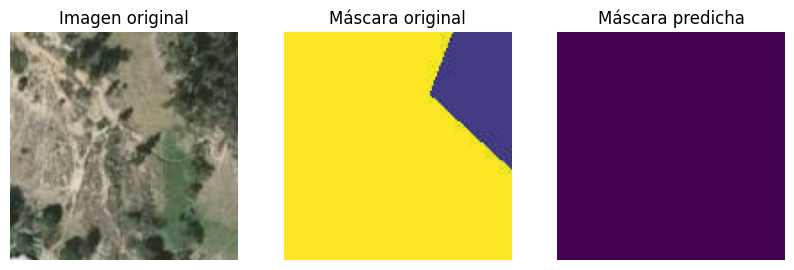

In [49]:
# Mostrar imagen, máscara y predicción

# Escoger una imagen aleatoriamente
id = np.random.randint(0,len(ds_test))

# Generar figura
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6))

# Imagen original
ax1.imshow(imgs[id])
ax1.set_title('Imagen original')
ax1.axis('off')

# Máscara original
ax2.imshow(msks[id])
ax2.set_title('Máscara original')
ax2.axis('off')

# Máscara predicha
ax3.imshow(mascaras[id])
ax3.set_title('Máscara predicha')
ax3.axis('off');